In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

import cv2

from unet import UNet
import scipy.optimize as optimize
from scipy.optimize import curve_fit

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_K2_5um_front_3M_100keV.txt"

In [ ]:
# Read a new dataset.
df = emsim_utils.read_electron_data(datfile,nevts=200005)
df.to_pickle("EM_5um_front_3M_100keV.pkl")

# Generate random multi-electron events

In [10]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

Created dataset for events from 0 to 198917


In [11]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [12]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 40):
    
    A = fit_img/np.max(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1.0 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

In [95]:
# Create some number of events and count them.
th_unet = 0.8
th_classical = 825
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    label = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    ct_classical = np.zeros(frame.shape)
    ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    l_frames.append(frame)
    l_labels.append(label)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


In [96]:
raw_th = 0.992
ct_th = 0.4
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

nzeros = 3.0146160574681558, ncts = 184.49340115462903, wcts = 1.0
m =  -1.8544189453125028 b =  27.8828125 Lmin= -187.37715613538847
nzeros = 210.0, ncts = 168.91891891891893, wcts = 1.0
m =  -1.941595458984378 b =  28.787109375 Lmin= -378.91891891891896
nzeros = 205.56448598130842, ncts = 154.69532710280373, wcts = 1.0
m =  -1.934326171875003 b =  28.796875 Lmin= -360.2598130841121
nzeros = 203.3422370617696, ncts = 160.28714524207012, wcts = 1.0
m =  -1.941595458984378 b =  28.787109375 Lmin= -363.62938230383975


Total counts, truth: 100000.0
Total counts, classical: 100000.0
Total counts, unet: 85135


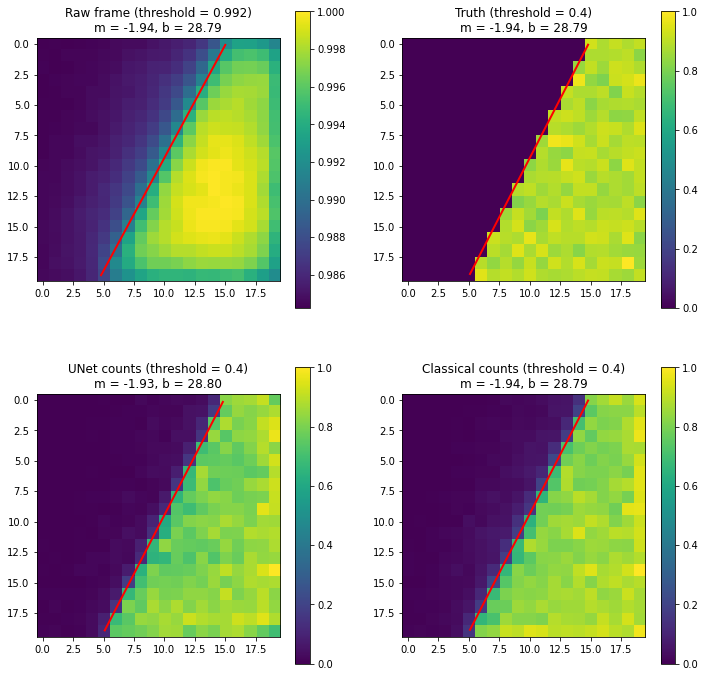

In [97]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_label,b_label))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_label,b_label))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
plt.title("Classical counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

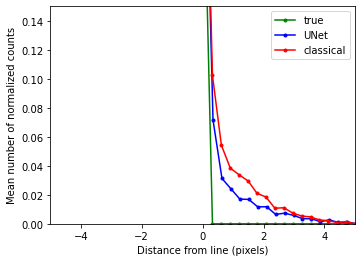

In [100]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
#plt.plot(bcenters_frame,hdist_frame,color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical')
plt.xlim([-5,5])
plt.ylim([0.0,0.15])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [101]:
# Save s-curve information.
np.savez("scurve_edge_th08.npz", bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

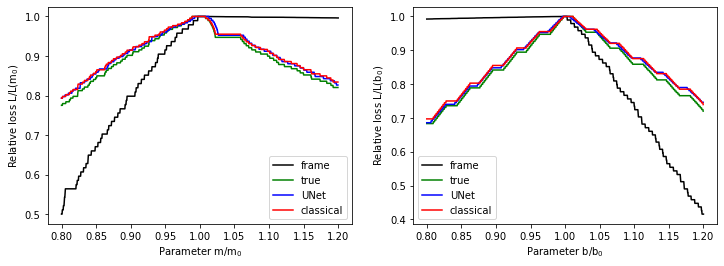

In [102]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

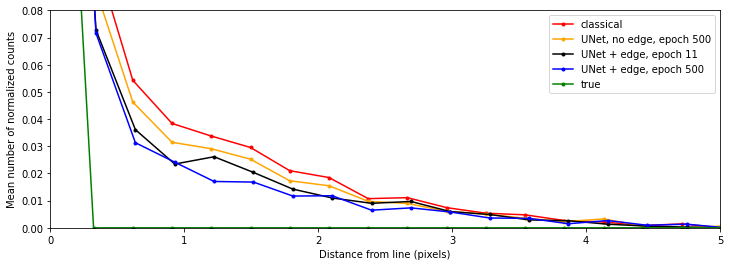

In [139]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(111)
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='black',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([0,5])
plt.ylim([0,0.08])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [93]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 500    # Number of final epoch
model_load_checkpoint = "{}/edge/model_init_499.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=8)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 198917


In [3]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  0


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/1000 (0%)]	Loss: 262.691772	 score_max: 0.949370	 score_min: -3.191103; Accuracy 0.997
Train Epoch: 0 [50/1000 (5%)]	Loss: 242.401642	 score_max: 0.722068	 score_min: -1.248078; Accuracy 0.998
Train Epoch: 0 [100/1000 (10%)]	Loss: 209.929688	 score_max: 1.122077	 score_min: -1.048244; Accuracy 0.997
Train Epoch: 0 [150/1000 (15%)]	Loss: 179.263199	 score_max: 0.691385	 score_min: -1.638906; Accuracy 0.998
Train Epoch: 0 [200/1000 (20%)]	Loss: 150.887177	 score_max: -0.234264	 score_min: -1.539174; Accuracy 0.998
Train Epoch: 0 [250/1000 (25%)]	Loss: 126.028198	 score_max: -0.472723	 score_min: -2.640405; Accuracy 0.998
Train Epoch: 0 [300/1000 (30%)]	Loss: 102.417374	 score_max: -0.595572	 score_min: -2.640349; Accuracy 0.998
Train Epoch: 0 [350/1000 (35%)]	Loss: 78.927986	 score_max: -0.692526	 score_min: -2.356207; Accuracy 0.998
Train Epoch: 0 [400/1000 (40%)]	Loss: 59.479362	 score_max: -1.042039	 score_min: -2.778927; Accuracy 0.998
Train Epoch: 0 [450/1000 (45%)

Train Epoch: 3 [800/1000 (80%)]	Loss: 1.315408	 score_max: -0.038618	 score_min: -63.070347; Accuracy 0.998
Train Epoch: 3 [850/1000 (85%)]	Loss: 1.126184	 score_max: -0.023963	 score_min: -65.037987; Accuracy 0.998
Train Epoch: 3 [900/1000 (90%)]	Loss: 1.071249	 score_max: -0.009377	 score_min: -65.836586; Accuracy 0.998
Train Epoch: 3 [950/1000 (95%)]	Loss: 1.085826	 score_max: 0.005140	 score_min: -80.517982; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 1.3066288828849792 ACCURACY: 0.9975000023841858
Epoch:  4
Train Epoch: 4 [0/1000 (0%)]	Loss: 2.006595	 score_max: 0.019589	 score_min: -66.991798; Accuracy 0.998
Train Epoch: 4 [50/1000 (5%)]	Loss: 1.383778	 score_max: 0.033971	 score_min: -73.802139; Accuracy 0.998
Train Epoch: 4 [100/1000 (10%)]	Loss: 1.148671	 score_max: 0.048286	 score_min: -57.746674; Accuracy 0.998
Train Epoch: 4 [150/1000 (15%)]	Loss: 0.990471	 score_max: 0.062535	 score_min: -41.578842; Accuracy 0.998
Train Epoch: 4 [200/1000 (20%)]	Loss: 1.183726	 score_max: 0.07

Train Epoch: 7 [750/1000 (75%)]	Loss: 1.112559	 score_max: 0.968967	 score_min: -78.575157; Accuracy 0.998
Train Epoch: 7 [800/1000 (80%)]	Loss: 0.699158	 score_max: 0.980480	 score_min: -42.091431; Accuracy 0.997
Train Epoch: 7 [850/1000 (85%)]	Loss: 1.084077	 score_max: 0.991974	 score_min: -52.570042; Accuracy 0.998
Train Epoch: 7 [900/1000 (90%)]	Loss: 1.602483	 score_max: 1.003353	 score_min: -54.631454; Accuracy 0.998
Train Epoch: 7 [950/1000 (95%)]	Loss: 0.787296	 score_max: 1.014725	 score_min: -44.130772; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.9145916998386383 ACCURACY: 0.9977224916219711
Epoch:  8
Train Epoch: 8 [0/1000 (0%)]	Loss: 0.674848	 score_max: 1.026089	 score_min: -49.085018; Accuracy 0.998
Train Epoch: 8 [50/1000 (5%)]	Loss: 0.812780	 score_max: 1.037444	 score_min: -52.731804; Accuracy 0.998
Train Epoch: 8 [100/1000 (10%)]	Loss: 0.984480	 score_max: 1.048789	 score_min: -56.229233; Accuracy 0.997
Train Epoch: 8 [150/1000 (15%)]	Loss: 0.674976	 score_max: 1.06012

Train Epoch: 11 [800/1000 (80%)]	Loss: 0.812432	 score_max: 1.707471	 score_min: -30.254679; Accuracy 0.998
Train Epoch: 11 [850/1000 (85%)]	Loss: 0.886764	 score_max: 1.715869	 score_min: -26.878796; Accuracy 0.998
Train Epoch: 11 [900/1000 (90%)]	Loss: 0.448322	 score_max: 1.724606	 score_min: -60.551659; Accuracy 0.998
Train Epoch: 11 [950/1000 (95%)]	Loss: 0.560360	 score_max: 1.733646	 score_min: -54.373348; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.718848392367363 ACCURACY: 0.9980499744415283
Epoch:  12
Train Epoch: 12 [0/1000 (0%)]	Loss: 0.827236	 score_max: 1.742781	 score_min: -75.373360; Accuracy 0.998
Train Epoch: 12 [50/1000 (5%)]	Loss: 0.789722	 score_max: 1.751984	 score_min: -67.151970; Accuracy 0.998
Train Epoch: 12 [100/1000 (10%)]	Loss: 0.794157	 score_max: 1.761124	 score_min: -39.308041; Accuracy 0.998
Train Epoch: 12 [150/1000 (15%)]	Loss: 0.320139	 score_max: 1.769822	 score_min: -27.878742; Accuracy 0.998
Train Epoch: 12 [200/1000 (20%)]	Loss: 0.843928	 score_max

Train Epoch: 15 [700/1000 (70%)]	Loss: 0.390704	 score_max: 2.226874	 score_min: -55.701496; Accuracy 0.998
Train Epoch: 15 [750/1000 (75%)]	Loss: 0.723885	 score_max: 2.233410	 score_min: -28.224428; Accuracy 0.998
Train Epoch: 15 [800/1000 (80%)]	Loss: 0.577754	 score_max: 2.240638	 score_min: -43.412914; Accuracy 0.998
Train Epoch: 15 [850/1000 (85%)]	Loss: 0.554385	 score_max: 2.247628	 score_min: -41.545002; Accuracy 0.998
Train Epoch: 15 [900/1000 (90%)]	Loss: 0.833223	 score_max: 2.255264	 score_min: -55.125259; Accuracy 0.997
Train Epoch: 15 [950/1000 (95%)]	Loss: 0.418115	 score_max: 2.262357	 score_min: -82.338936; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.647668433189392 ACCURACY: 0.9980074763298035
Epoch:  16
Train Epoch: 16 [0/1000 (0%)]	Loss: 0.559187	 score_max: 2.270086	 score_min: -32.532085; Accuracy 0.998
Train Epoch: 16 [50/1000 (5%)]	Loss: 0.458730	 score_max: 2.277140	 score_min: -49.052425; Accuracy 0.998
Train Epoch: 16 [100/1000 (10%)]	Loss: 0.899695	 score_max

Train Epoch: 19 [400/1000 (40%)]	Loss: 0.312442	 score_max: 2.616087	 score_min: -42.708832; Accuracy 0.998
Train Epoch: 19 [450/1000 (45%)]	Loss: 0.654087	 score_max: 2.619573	 score_min: -34.668484; Accuracy 0.998
Train Epoch: 19 [500/1000 (50%)]	Loss: 0.608631	 score_max: 2.621712	 score_min: -82.478455; Accuracy 0.998
Train Epoch: 19 [550/1000 (55%)]	Loss: 0.647926	 score_max: 2.624116	 score_min: -27.873289; Accuracy 0.998
Train Epoch: 19 [600/1000 (60%)]	Loss: 0.843100	 score_max: 2.625727	 score_min: -38.135326; Accuracy 0.998
Train Epoch: 19 [650/1000 (65%)]	Loss: 0.335496	 score_max: 2.627570	 score_min: -46.590054; Accuracy 0.998
Train Epoch: 19 [700/1000 (70%)]	Loss: 0.449855	 score_max: 2.629780	 score_min: -25.482344; Accuracy 0.998
Train Epoch: 19 [750/1000 (75%)]	Loss: 0.289209	 score_max: 2.633282	 score_min: -32.669037; Accuracy 0.999
Train Epoch: 19 [800/1000 (80%)]	Loss: 0.577759	 score_max: 2.637719	 score_min: -58.086800; Accuracy 0.998
Train Epoch: 19 [850/1000 (8

Train Epoch: 23 [100/1000 (10%)]	Loss: 0.698447	 score_max: 2.805177	 score_min: -27.105274; Accuracy 0.998
Train Epoch: 23 [150/1000 (15%)]	Loss: 0.572623	 score_max: 2.805312	 score_min: -83.576981; Accuracy 0.998
Train Epoch: 23 [200/1000 (20%)]	Loss: 0.729334	 score_max: 2.805397	 score_min: -164.067535; Accuracy 0.997
Train Epoch: 23 [250/1000 (25%)]	Loss: 0.265120	 score_max: 2.805344	 score_min: -77.059692; Accuracy 0.999
Train Epoch: 23 [300/1000 (30%)]	Loss: 0.837341	 score_max: 2.805218	 score_min: -61.397190; Accuracy 0.998
Train Epoch: 23 [350/1000 (35%)]	Loss: 0.803459	 score_max: 2.804989	 score_min: -31.184700; Accuracy 0.998
Train Epoch: 23 [400/1000 (40%)]	Loss: 0.763930	 score_max: 2.804647	 score_min: -33.228527; Accuracy 0.998
Train Epoch: 23 [450/1000 (45%)]	Loss: 0.286311	 score_max: 2.804200	 score_min: -66.539162; Accuracy 0.998
Train Epoch: 23 [500/1000 (50%)]	Loss: 0.767741	 score_max: 2.803748	 score_min: -48.911343; Accuracy 0.998
Train Epoch: 23 [550/1000 (

Train Epoch: 26 [800/1000 (80%)]	Loss: 0.535209	 score_max: 2.815067	 score_min: -69.318008; Accuracy 0.998
Train Epoch: 26 [850/1000 (85%)]	Loss: 0.437330	 score_max: 2.815083	 score_min: -74.914551; Accuracy 0.998
Train Epoch: 26 [900/1000 (90%)]	Loss: 0.553206	 score_max: 2.815102	 score_min: -54.081898; Accuracy 0.998
Train Epoch: 26 [950/1000 (95%)]	Loss: 0.349192	 score_max: 2.815125	 score_min: -37.802238; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5604339301586151 ACCURACY: 0.9978499799966812
Epoch:  27
Train Epoch: 27 [0/1000 (0%)]	Loss: 0.551024	 score_max: 2.815148	 score_min: -42.572430; Accuracy 0.999
Train Epoch: 27 [50/1000 (5%)]	Loss: 0.480165	 score_max: 2.815177	 score_min: -41.126713; Accuracy 0.999
Train Epoch: 27 [100/1000 (10%)]	Loss: 0.525060	 score_max: 2.815209	 score_min: -25.780216; Accuracy 0.998
Train Epoch: 27 [150/1000 (15%)]	Loss: 0.568775	 score_max: 2.815228	 score_min: -25.936909; Accuracy 0.998
Train Epoch: 27 [200/1000 (20%)]	Loss: 0.674405	 score_ma

Train Epoch: 30 [750/1000 (75%)]	Loss: 0.745204	 score_max: 2.818011	 score_min: -37.437496; Accuracy 0.998
Train Epoch: 30 [800/1000 (80%)]	Loss: 0.648666	 score_max: 2.818050	 score_min: -62.553623; Accuracy 0.998
Train Epoch: 30 [850/1000 (85%)]	Loss: 0.372373	 score_max: 2.818083	 score_min: -45.039127; Accuracy 0.998
Train Epoch: 30 [900/1000 (90%)]	Loss: 0.380582	 score_max: 2.818105	 score_min: -30.703821; Accuracy 0.998
Train Epoch: 30 [950/1000 (95%)]	Loss: 0.665520	 score_max: 2.818137	 score_min: -25.729374; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5170843854546547 ACCURACY: 0.9981974691152573
Epoch:  31
Train Epoch: 31 [0/1000 (0%)]	Loss: 1.064929	 score_max: 2.818172	 score_min: -81.931175; Accuracy 0.998
Train Epoch: 31 [50/1000 (5%)]	Loss: 0.644532	 score_max: 2.818216	 score_min: -30.054247; Accuracy 0.998
Train Epoch: 31 [100/1000 (10%)]	Loss: 0.318178	 score_max: 2.818273	 score_min: -37.308956; Accuracy 0.998
Train Epoch: 31 [150/1000 (15%)]	Loss: 0.789538	 score_ma

Train Epoch: 34 [400/1000 (40%)]	Loss: 0.553558	 score_max: 2.821912	 score_min: -26.142061; Accuracy 0.998
Train Epoch: 34 [450/1000 (45%)]	Loss: 0.576451	 score_max: 2.821976	 score_min: -63.455276; Accuracy 0.998
Train Epoch: 34 [500/1000 (50%)]	Loss: 0.629742	 score_max: 2.822040	 score_min: -35.598801; Accuracy 0.998
Train Epoch: 34 [550/1000 (55%)]	Loss: 0.800582	 score_max: 2.822080	 score_min: -46.193787; Accuracy 0.998
Train Epoch: 34 [600/1000 (60%)]	Loss: 0.560262	 score_max: 2.822116	 score_min: -84.910202; Accuracy 0.998
Train Epoch: 34 [650/1000 (65%)]	Loss: 0.793549	 score_max: 2.822140	 score_min: -34.537281; Accuracy 0.998
Train Epoch: 34 [700/1000 (70%)]	Loss: 0.398124	 score_max: 2.822165	 score_min: -25.546160; Accuracy 0.998
Train Epoch: 34 [750/1000 (75%)]	Loss: 0.561667	 score_max: 2.822196	 score_min: -100.063225; Accuracy 0.998
Train Epoch: 34 [800/1000 (80%)]	Loss: 0.756173	 score_max: 2.822243	 score_min: -27.320749; Accuracy 0.998
Train Epoch: 34 [850/1000 (

Train Epoch: 38 [200/1000 (20%)]	Loss: 0.774378	 score_max: 2.823478	 score_min: -64.727425; Accuracy 0.998
Train Epoch: 38 [250/1000 (25%)]	Loss: 0.600706	 score_max: 2.823480	 score_min: -82.963585; Accuracy 0.998
Train Epoch: 38 [300/1000 (30%)]	Loss: 0.226865	 score_max: 2.823483	 score_min: -25.191181; Accuracy 0.999
Train Epoch: 38 [350/1000 (35%)]	Loss: 0.267787	 score_max: 2.823486	 score_min: -41.698780; Accuracy 0.998
Train Epoch: 38 [400/1000 (40%)]	Loss: 0.332510	 score_max: 2.823490	 score_min: -26.569510; Accuracy 0.998
Train Epoch: 38 [450/1000 (45%)]	Loss: 0.657848	 score_max: 2.823494	 score_min: -26.707691; Accuracy 0.998
Train Epoch: 38 [500/1000 (50%)]	Loss: 0.491946	 score_max: 2.823498	 score_min: -69.984642; Accuracy 0.998
Train Epoch: 38 [550/1000 (55%)]	Loss: 0.538855	 score_max: 2.823503	 score_min: -44.358154; Accuracy 0.998
Train Epoch: 38 [600/1000 (60%)]	Loss: 0.482821	 score_max: 2.823508	 score_min: -30.671652; Accuracy 0.998
Train Epoch: 38 [650/1000 (6

Train Epoch: 42 [0/1000 (0%)]	Loss: 0.553856	 score_max: 2.823588	 score_min: -27.100906; Accuracy 0.998
Train Epoch: 42 [50/1000 (5%)]	Loss: 1.011015	 score_max: 2.823588	 score_min: -44.132885; Accuracy 0.997
Train Epoch: 42 [100/1000 (10%)]	Loss: 0.224544	 score_max: 2.823588	 score_min: -40.463341; Accuracy 0.999
Train Epoch: 42 [150/1000 (15%)]	Loss: 0.427084	 score_max: 2.823588	 score_min: -26.708975; Accuracy 0.998
Train Epoch: 42 [200/1000 (20%)]	Loss: 0.791458	 score_max: 2.823588	 score_min: -25.118950; Accuracy 0.998
Train Epoch: 42 [250/1000 (25%)]	Loss: 0.408183	 score_max: 2.823588	 score_min: -81.285629; Accuracy 0.998
Train Epoch: 42 [300/1000 (30%)]	Loss: 0.637615	 score_max: 2.823588	 score_min: -29.037777; Accuracy 0.998
Train Epoch: 42 [350/1000 (35%)]	Loss: 0.427547	 score_max: 2.823588	 score_min: -33.681679; Accuracy 0.998
Train Epoch: 42 [400/1000 (40%)]	Loss: 0.849476	 score_max: 2.823588	 score_min: -58.930614; Accuracy 0.998
Train Epoch: 42 [450/1000 (45%)]	

Train Epoch: 45 [800/1000 (80%)]	Loss: 0.736100	 score_max: 2.823588	 score_min: -48.475063; Accuracy 0.998
Train Epoch: 45 [850/1000 (85%)]	Loss: 0.509238	 score_max: 2.823588	 score_min: -60.642136; Accuracy 0.998
Train Epoch: 45 [900/1000 (90%)]	Loss: 1.091376	 score_max: 2.823588	 score_min: -30.319906; Accuracy 0.998
Train Epoch: 45 [950/1000 (95%)]	Loss: 0.355003	 score_max: 2.823588	 score_min: -27.071878; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5121261283755303 ACCURACY: 0.9981049686670304
Epoch:  46
Train Epoch: 46 [0/1000 (0%)]	Loss: 0.463274	 score_max: 2.823588	 score_min: -31.307329; Accuracy 0.998
Train Epoch: 46 [50/1000 (5%)]	Loss: 0.554323	 score_max: 2.823588	 score_min: -37.014538; Accuracy 0.998
Train Epoch: 46 [100/1000 (10%)]	Loss: 0.285800	 score_max: 2.823588	 score_min: -50.637115; Accuracy 0.998
Train Epoch: 46 [150/1000 (15%)]	Loss: 0.953933	 score_max: 2.823588	 score_min: -47.593422; Accuracy 0.998
Train Epoch: 46 [200/1000 (20%)]	Loss: 0.532288	 score_ma

Train Epoch: 49 [800/1000 (80%)]	Loss: 0.459318	 score_max: 2.823588	 score_min: -32.708225; Accuracy 0.998
Train Epoch: 49 [850/1000 (85%)]	Loss: 0.382494	 score_max: 2.823588	 score_min: -61.412464; Accuracy 0.998
Train Epoch: 49 [900/1000 (90%)]	Loss: 0.641953	 score_max: 2.823588	 score_min: -62.153301; Accuracy 0.999
Train Epoch: 49 [950/1000 (95%)]	Loss: 0.716297	 score_max: 2.823588	 score_min: -27.039318; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5565801858901978 ACCURACY: 0.9980049759149552
Epoch:  50
Train Epoch: 50 [0/1000 (0%)]	Loss: 0.441970	 score_max: 2.823588	 score_min: -47.362919; Accuracy 0.998
Train Epoch: 50 [50/1000 (5%)]	Loss: 0.394247	 score_max: 2.823588	 score_min: -25.701956; Accuracy 0.998
Train Epoch: 50 [100/1000 (10%)]	Loss: 0.430998	 score_max: 2.823588	 score_min: -52.851566; Accuracy 0.998
Train Epoch: 50 [150/1000 (15%)]	Loss: 0.488985	 score_max: 2.823588	 score_min: -25.399792; Accuracy 0.998
Train Epoch: 50 [200/1000 (20%)]	Loss: 0.459515	 score_ma

Train Epoch: 53 [500/1000 (50%)]	Loss: 0.368697	 score_max: 2.823588	 score_min: -26.266846; Accuracy 0.998
Train Epoch: 53 [550/1000 (55%)]	Loss: 0.489720	 score_max: 2.823588	 score_min: -37.843597; Accuracy 0.998
Train Epoch: 53 [600/1000 (60%)]	Loss: 0.969754	 score_max: 2.823588	 score_min: -37.664047; Accuracy 0.998
Train Epoch: 53 [650/1000 (65%)]	Loss: 0.560406	 score_max: 2.823588	 score_min: -45.193138; Accuracy 0.998
Train Epoch: 53 [700/1000 (70%)]	Loss: 0.778685	 score_max: 2.823588	 score_min: -53.782104; Accuracy 0.998
Train Epoch: 53 [750/1000 (75%)]	Loss: 0.231985	 score_max: 2.823588	 score_min: -35.349026; Accuracy 0.998
Train Epoch: 53 [800/1000 (80%)]	Loss: 0.285857	 score_max: 2.823588	 score_min: -26.425337; Accuracy 0.998
Train Epoch: 53 [850/1000 (85%)]	Loss: 0.418728	 score_max: 2.823588	 score_min: -25.649990; Accuracy 0.998
Train Epoch: 53 [900/1000 (90%)]	Loss: 0.595539	 score_max: 2.823588	 score_min: -25.816877; Accuracy 0.998
Train Epoch: 53 [950/1000 (9

Train Epoch: 57 [250/1000 (25%)]	Loss: 0.438795	 score_max: 2.823588	 score_min: -30.808050; Accuracy 0.998
Train Epoch: 57 [300/1000 (30%)]	Loss: 0.323246	 score_max: 2.823588	 score_min: -25.235893; Accuracy 0.998
Train Epoch: 57 [350/1000 (35%)]	Loss: 0.528440	 score_max: 2.823588	 score_min: -30.238718; Accuracy 0.998
Train Epoch: 57 [400/1000 (40%)]	Loss: 0.631112	 score_max: 2.823588	 score_min: -39.400425; Accuracy 0.998
Train Epoch: 57 [450/1000 (45%)]	Loss: 0.546092	 score_max: 2.823588	 score_min: -34.021820; Accuracy 0.998
Train Epoch: 57 [500/1000 (50%)]	Loss: 0.610196	 score_max: 2.823588	 score_min: -60.134502; Accuracy 0.998
Train Epoch: 57 [550/1000 (55%)]	Loss: 0.295323	 score_max: 2.823588	 score_min: -28.178724; Accuracy 0.999
Train Epoch: 57 [600/1000 (60%)]	Loss: 0.421386	 score_max: 2.823588	 score_min: -25.704412; Accuracy 0.998
Train Epoch: 57 [650/1000 (65%)]	Loss: 0.649092	 score_max: 2.823588	 score_min: -41.713768; Accuracy 0.998
Train Epoch: 57 [700/1000 (7

Train Epoch: 61 [0/1000 (0%)]	Loss: 0.699515	 score_max: 2.823588	 score_min: -52.554047; Accuracy 0.998
Train Epoch: 61 [50/1000 (5%)]	Loss: 0.918779	 score_max: 2.823588	 score_min: -79.542694; Accuracy 0.997
Train Epoch: 61 [100/1000 (10%)]	Loss: 0.619691	 score_max: 2.823588	 score_min: -28.044434; Accuracy 0.998
Train Epoch: 61 [150/1000 (15%)]	Loss: 0.364625	 score_max: 2.823588	 score_min: -100.258263; Accuracy 0.998
Train Epoch: 61 [200/1000 (20%)]	Loss: 0.356379	 score_max: 2.823588	 score_min: -24.691599; Accuracy 0.998
Train Epoch: 61 [250/1000 (25%)]	Loss: 0.376628	 score_max: 2.823588	 score_min: -25.255463; Accuracy 0.998
Train Epoch: 61 [300/1000 (30%)]	Loss: 0.513773	 score_max: 2.823588	 score_min: -65.528229; Accuracy 0.998
Train Epoch: 61 [350/1000 (35%)]	Loss: 0.744241	 score_max: 2.823588	 score_min: -43.395126; Accuracy 0.998
Train Epoch: 61 [400/1000 (40%)]	Loss: 0.314945	 score_max: 2.823588	 score_min: -35.246597; Accuracy 0.999
Train Epoch: 61 [450/1000 (45%)]

Train Epoch: 64 [800/1000 (80%)]	Loss: 0.434602	 score_max: 2.823588	 score_min: -26.523935; Accuracy 0.998
Train Epoch: 64 [850/1000 (85%)]	Loss: 0.248003	 score_max: 2.823588	 score_min: -26.285345; Accuracy 0.998
Train Epoch: 64 [900/1000 (90%)]	Loss: 0.549732	 score_max: 2.823588	 score_min: -48.401012; Accuracy 0.998
Train Epoch: 64 [950/1000 (95%)]	Loss: 0.263816	 score_max: 2.823588	 score_min: -49.370029; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4174465246498585 ACCURACY: 0.9981349736452103
Epoch:  65
Train Epoch: 65 [0/1000 (0%)]	Loss: 0.430286	 score_max: 2.823588	 score_min: -25.354536; Accuracy 0.998
Train Epoch: 65 [50/1000 (5%)]	Loss: 0.469290	 score_max: 2.823588	 score_min: -65.802330; Accuracy 0.998
Train Epoch: 65 [100/1000 (10%)]	Loss: 1.001871	 score_max: 2.823588	 score_min: -66.643723; Accuracy 0.997
Train Epoch: 65 [150/1000 (15%)]	Loss: 0.345726	 score_max: 2.823588	 score_min: -34.949356; Accuracy 0.998
Train Epoch: 65 [200/1000 (20%)]	Loss: 0.315217	 score_ma

Train Epoch: 68 [500/1000 (50%)]	Loss: 0.659208	 score_max: 2.823588	 score_min: -24.733292; Accuracy 0.998
Train Epoch: 68 [550/1000 (55%)]	Loss: 0.331180	 score_max: 2.823588	 score_min: -45.584991; Accuracy 0.998
Train Epoch: 68 [600/1000 (60%)]	Loss: 0.498971	 score_max: 2.823588	 score_min: -26.643322; Accuracy 0.999
Train Epoch: 68 [650/1000 (65%)]	Loss: 0.800719	 score_max: 2.823588	 score_min: -25.730124; Accuracy 0.998
Train Epoch: 68 [700/1000 (70%)]	Loss: 0.669989	 score_max: 2.823588	 score_min: -42.368641; Accuracy 0.998
Train Epoch: 68 [750/1000 (75%)]	Loss: 0.508525	 score_max: 2.823588	 score_min: -50.940414; Accuracy 0.998
Train Epoch: 68 [800/1000 (80%)]	Loss: 0.191334	 score_max: 2.823588	 score_min: -30.718485; Accuracy 0.998
Train Epoch: 68 [850/1000 (85%)]	Loss: 0.769755	 score_max: 2.823588	 score_min: -94.236191; Accuracy 0.998
Train Epoch: 68 [900/1000 (90%)]	Loss: 0.439576	 score_max: 2.823588	 score_min: -27.480742; Accuracy 0.998
Train Epoch: 68 [950/1000 (9

Train Epoch: 72 [400/1000 (40%)]	Loss: 0.665413	 score_max: 2.823588	 score_min: -39.565006; Accuracy 0.998
Train Epoch: 72 [450/1000 (45%)]	Loss: 0.709818	 score_max: 2.823588	 score_min: -25.409887; Accuracy 0.998
Train Epoch: 72 [500/1000 (50%)]	Loss: 0.636447	 score_max: 2.823588	 score_min: -25.069212; Accuracy 0.998
Train Epoch: 72 [550/1000 (55%)]	Loss: 0.376702	 score_max: 2.823588	 score_min: -26.851110; Accuracy 0.998
Train Epoch: 72 [600/1000 (60%)]	Loss: 0.477039	 score_max: 2.823588	 score_min: -34.363251; Accuracy 0.998
Train Epoch: 72 [650/1000 (65%)]	Loss: 0.466310	 score_max: 2.823588	 score_min: -27.581760; Accuracy 0.998
Train Epoch: 72 [700/1000 (70%)]	Loss: 0.564530	 score_max: 2.823588	 score_min: -59.241547; Accuracy 0.998
Train Epoch: 72 [750/1000 (75%)]	Loss: 0.228935	 score_max: 2.823588	 score_min: -27.339363; Accuracy 0.998
Train Epoch: 72 [800/1000 (80%)]	Loss: 0.606363	 score_max: 2.823588	 score_min: -25.861832; Accuracy 0.998
Train Epoch: 72 [850/1000 (8

Train Epoch: 76 [200/1000 (20%)]	Loss: 0.602956	 score_max: 2.823588	 score_min: -28.661854; Accuracy 0.998
Train Epoch: 76 [250/1000 (25%)]	Loss: 0.367739	 score_max: 2.823588	 score_min: -25.104763; Accuracy 0.998
Train Epoch: 76 [300/1000 (30%)]	Loss: 0.733730	 score_max: 2.823588	 score_min: -36.123272; Accuracy 0.998
Train Epoch: 76 [350/1000 (35%)]	Loss: 0.407519	 score_max: 2.823588	 score_min: -46.456718; Accuracy 0.998
Train Epoch: 76 [400/1000 (40%)]	Loss: 0.344953	 score_max: 2.823588	 score_min: -52.055077; Accuracy 0.998
Train Epoch: 76 [450/1000 (45%)]	Loss: 0.560617	 score_max: 2.823588	 score_min: -37.878086; Accuracy 0.998
Train Epoch: 76 [500/1000 (50%)]	Loss: 0.423167	 score_max: 2.823588	 score_min: -50.473362; Accuracy 0.998
Train Epoch: 76 [550/1000 (55%)]	Loss: 1.158171	 score_max: 2.823588	 score_min: -25.680952; Accuracy 0.998
Train Epoch: 76 [600/1000 (60%)]	Loss: 0.715124	 score_max: 2.823588	 score_min: -46.367409; Accuracy 0.998
Train Epoch: 76 [650/1000 (6

Train Epoch: 80 [0/1000 (0%)]	Loss: 0.844744	 score_max: 2.823588	 score_min: -25.844120; Accuracy 0.998
Train Epoch: 80 [50/1000 (5%)]	Loss: 0.572172	 score_max: 2.823588	 score_min: -87.027748; Accuracy 0.998
Train Epoch: 80 [100/1000 (10%)]	Loss: 0.583349	 score_max: 2.823588	 score_min: -77.557144; Accuracy 0.998
Train Epoch: 80 [150/1000 (15%)]	Loss: 0.565329	 score_max: 2.823588	 score_min: -33.814171; Accuracy 0.999
Train Epoch: 80 [200/1000 (20%)]	Loss: 0.290902	 score_max: 2.823588	 score_min: -25.663271; Accuracy 0.998
Train Epoch: 80 [250/1000 (25%)]	Loss: 0.377783	 score_max: 2.823588	 score_min: -25.691885; Accuracy 0.998
Train Epoch: 80 [300/1000 (30%)]	Loss: 0.454338	 score_max: 2.823588	 score_min: -25.008245; Accuracy 0.998
Train Epoch: 80 [350/1000 (35%)]	Loss: 0.919692	 score_max: 2.823588	 score_min: -36.089699; Accuracy 0.998
Train Epoch: 80 [400/1000 (40%)]	Loss: 0.469169	 score_max: 2.823588	 score_min: -26.254883; Accuracy 0.998
Train Epoch: 80 [450/1000 (45%)]	

Train Epoch: 83 [800/1000 (80%)]	Loss: 0.654094	 score_max: 2.823588	 score_min: -51.264572; Accuracy 0.997
Train Epoch: 83 [850/1000 (85%)]	Loss: 0.320890	 score_max: 2.823588	 score_min: -26.128124; Accuracy 0.998
Train Epoch: 83 [900/1000 (90%)]	Loss: 0.678513	 score_max: 2.823588	 score_min: -28.767092; Accuracy 0.998
Train Epoch: 83 [950/1000 (95%)]	Loss: 0.370932	 score_max: 2.823588	 score_min: -53.919266; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.48477972894906995 ACCURACY: 0.9980949729681015
Epoch:  84
Train Epoch: 84 [0/1000 (0%)]	Loss: 0.577984	 score_max: 2.823588	 score_min: -67.199875; Accuracy 0.998
Train Epoch: 84 [50/1000 (5%)]	Loss: 0.547320	 score_max: 2.823588	 score_min: -79.292648; Accuracy 0.998
Train Epoch: 84 [100/1000 (10%)]	Loss: 0.560401	 score_max: 2.823588	 score_min: -70.349167; Accuracy 0.998
Train Epoch: 84 [150/1000 (15%)]	Loss: 0.646787	 score_max: 2.823588	 score_min: -25.948477; Accuracy 0.998
Train Epoch: 84 [200/1000 (20%)]	Loss: 0.599114	 score_m

Train Epoch: 87 [550/1000 (55%)]	Loss: 0.762827	 score_max: 2.823588	 score_min: -27.713064; Accuracy 0.998
Train Epoch: 87 [600/1000 (60%)]	Loss: 0.616728	 score_max: 2.823588	 score_min: -52.854324; Accuracy 0.997
Train Epoch: 87 [650/1000 (65%)]	Loss: 0.629392	 score_max: 2.823588	 score_min: -26.001095; Accuracy 0.998
Train Epoch: 87 [700/1000 (70%)]	Loss: 0.533285	 score_max: 2.823588	 score_min: -26.335867; Accuracy 0.998
Train Epoch: 87 [750/1000 (75%)]	Loss: 0.410896	 score_max: 2.823588	 score_min: -40.425266; Accuracy 0.998
Train Epoch: 87 [800/1000 (80%)]	Loss: 0.223177	 score_max: 2.823588	 score_min: -35.602291; Accuracy 0.998
Train Epoch: 87 [850/1000 (85%)]	Loss: 0.359784	 score_max: 2.823588	 score_min: -41.985970; Accuracy 0.998
Train Epoch: 87 [900/1000 (90%)]	Loss: 0.361219	 score_max: 2.823588	 score_min: -84.519966; Accuracy 0.998
Train Epoch: 87 [950/1000 (95%)]	Loss: 0.332192	 score_max: 2.823588	 score_min: -25.500263; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5

Train Epoch: 91 [250/1000 (25%)]	Loss: 0.793348	 score_max: 2.823588	 score_min: -25.687054; Accuracy 0.998
Train Epoch: 91 [300/1000 (30%)]	Loss: 0.824579	 score_max: 2.823588	 score_min: -34.074894; Accuracy 0.998
Train Epoch: 91 [350/1000 (35%)]	Loss: 0.378148	 score_max: 2.823588	 score_min: -25.603106; Accuracy 0.998
Train Epoch: 91 [400/1000 (40%)]	Loss: 0.533832	 score_max: 2.823588	 score_min: -44.535305; Accuracy 0.998
Train Epoch: 91 [450/1000 (45%)]	Loss: 0.190522	 score_max: 2.823588	 score_min: -27.607519; Accuracy 0.998
Train Epoch: 91 [500/1000 (50%)]	Loss: 0.368265	 score_max: 2.823588	 score_min: -27.034492; Accuracy 0.998
Train Epoch: 91 [550/1000 (55%)]	Loss: 1.196610	 score_max: 2.823588	 score_min: -45.592442; Accuracy 0.998
Train Epoch: 91 [600/1000 (60%)]	Loss: 0.621521	 score_max: 2.823588	 score_min: -36.685513; Accuracy 0.998
Train Epoch: 91 [650/1000 (65%)]	Loss: 0.595923	 score_max: 2.823588	 score_min: -26.191936; Accuracy 0.998
Train Epoch: 91 [700/1000 (7

Train Epoch: 95 [0/1000 (0%)]	Loss: 0.426977	 score_max: 2.823588	 score_min: -95.774445; Accuracy 0.998
Train Epoch: 95 [50/1000 (5%)]	Loss: 0.529770	 score_max: 2.823588	 score_min: -26.710073; Accuracy 0.998
Train Epoch: 95 [100/1000 (10%)]	Loss: 0.489730	 score_max: 2.823588	 score_min: -34.987347; Accuracy 0.998
Train Epoch: 95 [150/1000 (15%)]	Loss: 0.521576	 score_max: 2.823588	 score_min: -25.556978; Accuracy 0.998
Train Epoch: 95 [200/1000 (20%)]	Loss: 0.485007	 score_max: 2.823588	 score_min: -26.865294; Accuracy 0.998
Train Epoch: 95 [250/1000 (25%)]	Loss: 0.530934	 score_max: 2.823588	 score_min: -34.858944; Accuracy 0.998
Train Epoch: 95 [300/1000 (30%)]	Loss: 0.300660	 score_max: 2.823588	 score_min: -32.322872; Accuracy 0.998
Train Epoch: 95 [350/1000 (35%)]	Loss: 0.549615	 score_max: 2.823588	 score_min: -24.278410; Accuracy 0.999
Train Epoch: 95 [400/1000 (40%)]	Loss: 0.354862	 score_max: 2.823588	 score_min: -32.004456; Accuracy 0.998
Train Epoch: 95 [450/1000 (45%)]	

Train Epoch: 98 [800/1000 (80%)]	Loss: 1.045933	 score_max: 2.823588	 score_min: -29.143732; Accuracy 0.998
Train Epoch: 98 [850/1000 (85%)]	Loss: 0.414477	 score_max: 2.823588	 score_min: -98.521652; Accuracy 0.998
Train Epoch: 98 [900/1000 (90%)]	Loss: 0.565452	 score_max: 2.823588	 score_min: -27.349663; Accuracy 0.998
Train Epoch: 98 [950/1000 (95%)]	Loss: 0.673104	 score_max: 2.823588	 score_min: -26.453337; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5329333581030369 ACCURACY: 0.9980549782514572
Epoch:  99
Train Epoch: 99 [0/1000 (0%)]	Loss: 0.499704	 score_max: 2.823588	 score_min: -51.051357; Accuracy 0.998
Train Epoch: 99 [50/1000 (5%)]	Loss: 0.631856	 score_max: 2.823588	 score_min: -62.584591; Accuracy 0.998
Train Epoch: 99 [100/1000 (10%)]	Loss: 0.362922	 score_max: 2.823588	 score_min: -43.622349; Accuracy 0.998
Train Epoch: 99 [150/1000 (15%)]	Loss: 0.691076	 score_max: 2.823588	 score_min: -34.951111; Accuracy 0.998
Train Epoch: 99 [200/1000 (20%)]	Loss: 0.945405	 score_ma

Train Epoch: 102 [750/1000 (75%)]	Loss: 0.197448	 score_max: 2.823588	 score_min: -54.670124; Accuracy 0.998
Train Epoch: 102 [800/1000 (80%)]	Loss: 0.537019	 score_max: 2.823588	 score_min: -69.236115; Accuracy 0.998
Train Epoch: 102 [850/1000 (85%)]	Loss: 0.258388	 score_max: 2.823588	 score_min: -49.182331; Accuracy 0.998
Train Epoch: 102 [900/1000 (90%)]	Loss: 0.388276	 score_max: 2.823588	 score_min: -37.375267; Accuracy 0.998
Train Epoch: 102 [950/1000 (95%)]	Loss: 0.289773	 score_max: 2.823588	 score_min: -26.114513; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4605615846812725 ACCURACY: 0.998049971461296
Epoch:  103
Train Epoch: 103 [0/1000 (0%)]	Loss: 0.635466	 score_max: 2.823588	 score_min: -38.593716; Accuracy 0.998
Train Epoch: 103 [50/1000 (5%)]	Loss: 0.412765	 score_max: 2.823588	 score_min: -25.617479; Accuracy 0.998
Train Epoch: 103 [100/1000 (10%)]	Loss: 0.435252	 score_max: 2.823588	 score_min: -59.917713; Accuracy 0.997
Train Epoch: 103 [150/1000 (15%)]	Loss: 0.678069	

Train Epoch: 106 [400/1000 (40%)]	Loss: 0.287505	 score_max: 2.823588	 score_min: -43.586761; Accuracy 0.998
Train Epoch: 106 [450/1000 (45%)]	Loss: 0.544193	 score_max: 2.823588	 score_min: -26.526539; Accuracy 0.998
Train Epoch: 106 [500/1000 (50%)]	Loss: 0.516283	 score_max: 2.823588	 score_min: -68.741264; Accuracy 0.998
Train Epoch: 106 [550/1000 (55%)]	Loss: 0.549507	 score_max: 2.823588	 score_min: -28.733669; Accuracy 0.998
Train Epoch: 106 [600/1000 (60%)]	Loss: 0.290464	 score_max: 2.823588	 score_min: -45.514915; Accuracy 0.998
Train Epoch: 106 [650/1000 (65%)]	Loss: 0.321208	 score_max: 2.823588	 score_min: -24.918995; Accuracy 0.998
Train Epoch: 106 [700/1000 (70%)]	Loss: 0.312077	 score_max: 2.823588	 score_min: -47.872200; Accuracy 0.998
Train Epoch: 106 [750/1000 (75%)]	Loss: 0.403220	 score_max: 2.823588	 score_min: -26.923798; Accuracy 0.998
Train Epoch: 106 [800/1000 (80%)]	Loss: 0.539040	 score_max: 2.823588	 score_min: -81.679268; Accuracy 0.998
Train Epoch: 106 [8

Train Epoch: 110 [150/1000 (15%)]	Loss: 0.551881	 score_max: 2.823588	 score_min: -30.975250; Accuracy 0.998
Train Epoch: 110 [200/1000 (20%)]	Loss: 0.327027	 score_max: 2.823588	 score_min: -48.134739; Accuracy 0.998
Train Epoch: 110 [250/1000 (25%)]	Loss: 0.431926	 score_max: 2.823588	 score_min: -27.543873; Accuracy 0.998
Train Epoch: 110 [300/1000 (30%)]	Loss: 0.328555	 score_max: 2.823588	 score_min: -57.447815; Accuracy 0.998
Train Epoch: 110 [350/1000 (35%)]	Loss: 0.504661	 score_max: 2.823588	 score_min: -29.802258; Accuracy 0.998
Train Epoch: 110 [400/1000 (40%)]	Loss: 0.958264	 score_max: 2.823588	 score_min: -40.446651; Accuracy 0.998
Train Epoch: 110 [450/1000 (45%)]	Loss: 0.499378	 score_max: 2.823588	 score_min: -29.511536; Accuracy 0.998
Train Epoch: 110 [500/1000 (50%)]	Loss: 0.859805	 score_max: 2.823588	 score_min: -29.916878; Accuracy 0.998
Train Epoch: 110 [550/1000 (55%)]	Loss: 0.453692	 score_max: 2.823588	 score_min: -37.041431; Accuracy 0.998
Train Epoch: 110 [6

Train Epoch: 113 [800/1000 (80%)]	Loss: 0.444379	 score_max: 2.823588	 score_min: -40.156342; Accuracy 0.998
Train Epoch: 113 [850/1000 (85%)]	Loss: 0.352765	 score_max: 2.823588	 score_min: -27.796104; Accuracy 0.998
Train Epoch: 113 [900/1000 (90%)]	Loss: 0.636344	 score_max: 2.823588	 score_min: -40.850861; Accuracy 0.998
Train Epoch: 113 [950/1000 (95%)]	Loss: 0.426268	 score_max: 2.823588	 score_min: -45.201508; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.6070682778954506 ACCURACY: 0.9979424715042114
Epoch:  114
Train Epoch: 114 [0/1000 (0%)]	Loss: 0.536863	 score_max: 2.823588	 score_min: -27.186954; Accuracy 0.998
Train Epoch: 114 [50/1000 (5%)]	Loss: 0.495565	 score_max: 2.823588	 score_min: -26.207958; Accuracy 0.998
Train Epoch: 114 [100/1000 (10%)]	Loss: 0.465242	 score_max: 2.823588	 score_min: -26.642654; Accuracy 0.998
Train Epoch: 114 [150/1000 (15%)]	Loss: 0.672563	 score_max: 2.823588	 score_min: -27.763390; Accuracy 0.998
Train Epoch: 114 [200/1000 (20%)]	Loss: 0.328568

Train Epoch: 117 [800/1000 (80%)]	Loss: 0.383940	 score_max: 2.823588	 score_min: -32.159969; Accuracy 0.998
Train Epoch: 117 [850/1000 (85%)]	Loss: 0.591386	 score_max: 2.823588	 score_min: -67.744385; Accuracy 0.998
Train Epoch: 117 [900/1000 (90%)]	Loss: 0.505218	 score_max: 2.823588	 score_min: -39.392838; Accuracy 0.998
Train Epoch: 117 [950/1000 (95%)]	Loss: 0.494489	 score_max: 2.823588	 score_min: -27.077686; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5581427305936814 ACCURACY: 0.998087465763092
Epoch:  118
Train Epoch: 118 [0/1000 (0%)]	Loss: 0.518873	 score_max: 2.823588	 score_min: -44.203720; Accuracy 0.998
Train Epoch: 118 [50/1000 (5%)]	Loss: 0.661167	 score_max: 2.823588	 score_min: -64.214706; Accuracy 0.998
Train Epoch: 118 [100/1000 (10%)]	Loss: 0.640330	 score_max: 2.823588	 score_min: -33.387173; Accuracy 0.997
Train Epoch: 118 [150/1000 (15%)]	Loss: 0.471037	 score_max: 2.823588	 score_min: -31.356934; Accuracy 0.998
Train Epoch: 118 [200/1000 (20%)]	Loss: 0.781341	

Train Epoch: 121 [450/1000 (45%)]	Loss: 1.193011	 score_max: 2.823588	 score_min: -38.710777; Accuracy 0.997
Train Epoch: 121 [500/1000 (50%)]	Loss: 0.402463	 score_max: 2.823588	 score_min: -47.319469; Accuracy 0.998
Train Epoch: 121 [550/1000 (55%)]	Loss: 0.504992	 score_max: 2.823588	 score_min: -26.580967; Accuracy 0.998
Train Epoch: 121 [600/1000 (60%)]	Loss: 0.375054	 score_max: 2.823588	 score_min: -55.598061; Accuracy 0.998
Train Epoch: 121 [650/1000 (65%)]	Loss: 0.574677	 score_max: 2.823588	 score_min: -26.394562; Accuracy 0.998
Train Epoch: 121 [700/1000 (70%)]	Loss: 0.582361	 score_max: 2.823588	 score_min: -43.837578; Accuracy 0.998
Train Epoch: 121 [750/1000 (75%)]	Loss: 0.735780	 score_max: 2.823588	 score_min: -26.112877; Accuracy 0.998
Train Epoch: 121 [800/1000 (80%)]	Loss: 0.782118	 score_max: 2.823588	 score_min: -47.226250; Accuracy 0.998
Train Epoch: 121 [850/1000 (85%)]	Loss: 0.380626	 score_max: 2.823588	 score_min: -27.402386; Accuracy 0.998
Train Epoch: 121 [9

Train Epoch: 125 [150/1000 (15%)]	Loss: 0.340216	 score_max: 2.823588	 score_min: -32.267567; Accuracy 0.998
Train Epoch: 125 [200/1000 (20%)]	Loss: 0.714802	 score_max: 2.823588	 score_min: -26.284954; Accuracy 0.998
Train Epoch: 125 [250/1000 (25%)]	Loss: 0.722645	 score_max: 2.823588	 score_min: -24.431675; Accuracy 0.998
Train Epoch: 125 [300/1000 (30%)]	Loss: 0.567000	 score_max: 2.823588	 score_min: -31.060966; Accuracy 0.998
Train Epoch: 125 [350/1000 (35%)]	Loss: 0.553922	 score_max: 2.823588	 score_min: -29.068893; Accuracy 0.998
Train Epoch: 125 [400/1000 (40%)]	Loss: 0.522285	 score_max: 2.823588	 score_min: -71.009895; Accuracy 0.998
Train Epoch: 125 [450/1000 (45%)]	Loss: 0.784354	 score_max: 2.823588	 score_min: -35.606636; Accuracy 0.998
Train Epoch: 125 [500/1000 (50%)]	Loss: 0.693774	 score_max: 2.823588	 score_min: -50.076302; Accuracy 0.998
Train Epoch: 125 [550/1000 (55%)]	Loss: 0.561597	 score_max: 2.823588	 score_min: -26.618481; Accuracy 0.998
Train Epoch: 125 [6

Train Epoch: 128 [800/1000 (80%)]	Loss: 0.765500	 score_max: 2.823588	 score_min: -26.827164; Accuracy 0.998
Train Epoch: 128 [850/1000 (85%)]	Loss: 0.423352	 score_max: 2.823588	 score_min: -25.855381; Accuracy 0.998
Train Epoch: 128 [900/1000 (90%)]	Loss: 0.978186	 score_max: 2.823588	 score_min: -33.169209; Accuracy 0.998
Train Epoch: 128 [950/1000 (95%)]	Loss: 0.243724	 score_max: 2.823588	 score_min: -55.118511; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4993542179465294 ACCURACY: 0.998209971189499
Epoch:  129
Train Epoch: 129 [0/1000 (0%)]	Loss: 0.657480	 score_max: 2.823588	 score_min: -29.428226; Accuracy 0.998
Train Epoch: 129 [50/1000 (5%)]	Loss: 0.882756	 score_max: 2.823588	 score_min: -35.606258; Accuracy 0.997
Train Epoch: 129 [100/1000 (10%)]	Loss: 0.550651	 score_max: 2.823588	 score_min: -43.653591; Accuracy 0.998
Train Epoch: 129 [150/1000 (15%)]	Loss: 0.471543	 score_max: 2.823588	 score_min: -60.315941; Accuracy 0.998
Train Epoch: 129 [200/1000 (20%)]	Loss: 0.524907	

Train Epoch: 132 [750/1000 (75%)]	Loss: 0.507637	 score_max: 2.823588	 score_min: -32.701706; Accuracy 0.998
Train Epoch: 132 [800/1000 (80%)]	Loss: 0.407294	 score_max: 2.823588	 score_min: -26.988281; Accuracy 0.999
Train Epoch: 132 [850/1000 (85%)]	Loss: 0.630900	 score_max: 2.823588	 score_min: -34.994411; Accuracy 0.998
Train Epoch: 132 [900/1000 (90%)]	Loss: 0.358968	 score_max: 2.823588	 score_min: -31.206650; Accuracy 0.998
Train Epoch: 132 [950/1000 (95%)]	Loss: 0.382990	 score_max: 2.823588	 score_min: -25.308895; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.46690156534314153 ACCURACY: 0.9980924755334855
Epoch:  133
Train Epoch: 133 [0/1000 (0%)]	Loss: 0.776043	 score_max: 2.823588	 score_min: -41.277916; Accuracy 0.999
Train Epoch: 133 [50/1000 (5%)]	Loss: 0.638303	 score_max: 2.823588	 score_min: -45.932457; Accuracy 0.999
Train Epoch: 133 [100/1000 (10%)]	Loss: 0.683624	 score_max: 2.823588	 score_min: -32.241837; Accuracy 0.998
Train Epoch: 133 [150/1000 (15%)]	Loss: 0.68705

Train Epoch: 136 [400/1000 (40%)]	Loss: 0.532857	 score_max: 2.823588	 score_min: -38.015678; Accuracy 0.998
Train Epoch: 136 [450/1000 (45%)]	Loss: 0.514031	 score_max: 2.823588	 score_min: -25.683487; Accuracy 0.998
Train Epoch: 136 [500/1000 (50%)]	Loss: 0.773411	 score_max: 2.823588	 score_min: -96.622482; Accuracy 0.998
Train Epoch: 136 [550/1000 (55%)]	Loss: 0.294624	 score_max: 2.823588	 score_min: -33.330448; Accuracy 0.997
Train Epoch: 136 [600/1000 (60%)]	Loss: 0.233926	 score_max: 2.823588	 score_min: -31.826191; Accuracy 0.998
Train Epoch: 136 [650/1000 (65%)]	Loss: 0.626016	 score_max: 2.823588	 score_min: -27.416847; Accuracy 0.998
Train Epoch: 136 [700/1000 (70%)]	Loss: 0.477224	 score_max: 2.823588	 score_min: -26.886208; Accuracy 0.998
Train Epoch: 136 [750/1000 (75%)]	Loss: 0.825554	 score_max: 2.823588	 score_min: -26.450310; Accuracy 0.998
Train Epoch: 136 [800/1000 (80%)]	Loss: 0.381907	 score_max: 2.823588	 score_min: -28.288303; Accuracy 0.998
Train Epoch: 136 [8

Train Epoch: 140 [150/1000 (15%)]	Loss: 0.530461	 score_max: 2.823588	 score_min: -27.562042; Accuracy 0.998
Train Epoch: 140 [200/1000 (20%)]	Loss: 0.464269	 score_max: 2.823588	 score_min: -32.451218; Accuracy 0.998
Train Epoch: 140 [250/1000 (25%)]	Loss: 0.193618	 score_max: 2.823588	 score_min: -37.894596; Accuracy 0.998
Train Epoch: 140 [300/1000 (30%)]	Loss: 0.440545	 score_max: 2.823588	 score_min: -45.622112; Accuracy 0.998
Train Epoch: 140 [350/1000 (35%)]	Loss: 0.380266	 score_max: 2.823588	 score_min: -26.869705; Accuracy 0.997
Train Epoch: 140 [400/1000 (40%)]	Loss: 0.428865	 score_max: 2.823588	 score_min: -30.963432; Accuracy 0.998
Train Epoch: 140 [450/1000 (45%)]	Loss: 0.678929	 score_max: 2.823588	 score_min: -28.433727; Accuracy 0.998
Train Epoch: 140 [500/1000 (50%)]	Loss: 0.639990	 score_max: 2.823588	 score_min: -48.296848; Accuracy 0.998
Train Epoch: 140 [550/1000 (55%)]	Loss: 0.591509	 score_max: 2.823588	 score_min: -49.625954; Accuracy 0.998
Train Epoch: 140 [6

Train Epoch: 143 [800/1000 (80%)]	Loss: 0.621296	 score_max: 2.823588	 score_min: -46.779804; Accuracy 0.998
Train Epoch: 143 [850/1000 (85%)]	Loss: 0.401498	 score_max: 2.823588	 score_min: -52.277630; Accuracy 0.999
Train Epoch: 143 [900/1000 (90%)]	Loss: 0.732209	 score_max: 2.823588	 score_min: -33.922569; Accuracy 0.998
Train Epoch: 143 [950/1000 (95%)]	Loss: 0.613039	 score_max: 2.823588	 score_min: -31.915527; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4803503781557083 ACCURACY: 0.998189976811409
Epoch:  144
Train Epoch: 144 [0/1000 (0%)]	Loss: 0.554303	 score_max: 2.823588	 score_min: -39.423771; Accuracy 0.998
Train Epoch: 144 [50/1000 (5%)]	Loss: 0.659833	 score_max: 2.823588	 score_min: -48.614994; Accuracy 0.998
Train Epoch: 144 [100/1000 (10%)]	Loss: 0.217013	 score_max: 2.823588	 score_min: -26.529713; Accuracy 0.998
Train Epoch: 144 [150/1000 (15%)]	Loss: 0.641052	 score_max: 2.823588	 score_min: -26.823177; Accuracy 0.998
Train Epoch: 144 [200/1000 (20%)]	Loss: 0.458821	

Train Epoch: 147 [800/1000 (80%)]	Loss: 0.741148	 score_max: 2.823588	 score_min: -29.630337; Accuracy 0.998
Train Epoch: 147 [850/1000 (85%)]	Loss: 0.418705	 score_max: 2.823588	 score_min: -28.474762; Accuracy 0.998
Train Epoch: 147 [900/1000 (90%)]	Loss: 0.843101	 score_max: 2.823588	 score_min: -54.325161; Accuracy 0.998
Train Epoch: 147 [950/1000 (95%)]	Loss: 0.318120	 score_max: 2.823588	 score_min: -33.620033; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5171263426542282 ACCURACY: 0.9980374842882156
Epoch:  148
Train Epoch: 148 [0/1000 (0%)]	Loss: 0.318485	 score_max: 2.823588	 score_min: -26.392944; Accuracy 0.998
Train Epoch: 148 [50/1000 (5%)]	Loss: 0.691991	 score_max: 2.823588	 score_min: -29.630527; Accuracy 0.998
Train Epoch: 148 [100/1000 (10%)]	Loss: 0.930904	 score_max: 2.823588	 score_min: -55.663193; Accuracy 0.998
Train Epoch: 148 [150/1000 (15%)]	Loss: 0.320479	 score_max: 2.823588	 score_min: -30.294720; Accuracy 0.998
Train Epoch: 148 [200/1000 (20%)]	Loss: 0.584650

Train Epoch: 151 [800/1000 (80%)]	Loss: 0.506254	 score_max: 2.823588	 score_min: -37.932312; Accuracy 0.998
Train Epoch: 151 [850/1000 (85%)]	Loss: 0.574282	 score_max: 2.823588	 score_min: -27.583687; Accuracy 0.998
Train Epoch: 151 [900/1000 (90%)]	Loss: 0.262063	 score_max: 2.823588	 score_min: -32.582085; Accuracy 0.998
Train Epoch: 151 [950/1000 (95%)]	Loss: 0.523861	 score_max: 2.823588	 score_min: -25.028664; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5204270943999291 ACCURACY: 0.9980024784803391
Epoch:  152
Train Epoch: 152 [0/1000 (0%)]	Loss: 0.307656	 score_max: 2.823588	 score_min: -36.512547; Accuracy 0.998
Train Epoch: 152 [50/1000 (5%)]	Loss: 0.362512	 score_max: 2.823588	 score_min: -49.634552; Accuracy 0.998
Train Epoch: 152 [100/1000 (10%)]	Loss: 0.526343	 score_max: 2.823588	 score_min: -28.914131; Accuracy 0.998
Train Epoch: 152 [150/1000 (15%)]	Loss: 0.471008	 score_max: 2.823588	 score_min: -73.292686; Accuracy 0.998
Train Epoch: 152 [200/1000 (20%)]	Loss: 0.633634

Train Epoch: 155 [550/1000 (55%)]	Loss: 0.408201	 score_max: 2.823588	 score_min: -28.984673; Accuracy 0.998
Train Epoch: 155 [600/1000 (60%)]	Loss: 0.338998	 score_max: 2.823588	 score_min: -30.688499; Accuracy 0.998
Train Epoch: 155 [650/1000 (65%)]	Loss: 0.518339	 score_max: 2.823588	 score_min: -24.605419; Accuracy 0.998
Train Epoch: 155 [700/1000 (70%)]	Loss: 0.437096	 score_max: 2.823588	 score_min: -25.079437; Accuracy 0.998
Train Epoch: 155 [750/1000 (75%)]	Loss: 0.576320	 score_max: 2.823588	 score_min: -30.370052; Accuracy 0.998
Train Epoch: 155 [800/1000 (80%)]	Loss: 0.393493	 score_max: 2.823588	 score_min: -24.632641; Accuracy 0.998
Train Epoch: 155 [850/1000 (85%)]	Loss: 0.519910	 score_max: 2.823588	 score_min: -34.204483; Accuracy 0.998
Train Epoch: 155 [900/1000 (90%)]	Loss: 0.671814	 score_max: 2.823588	 score_min: -36.675922; Accuracy 0.998
Train Epoch: 155 [950/1000 (95%)]	Loss: 0.734460	 score_max: 2.823588	 score_min: -31.218544; Accuracy 0.998
---EPOCH AVG TRAIN 

Train Epoch: 159 [200/1000 (20%)]	Loss: 0.506621	 score_max: 2.823588	 score_min: -25.052151; Accuracy 0.998
Train Epoch: 159 [250/1000 (25%)]	Loss: 0.261470	 score_max: 2.823588	 score_min: -66.421974; Accuracy 0.998
Train Epoch: 159 [300/1000 (30%)]	Loss: 0.768219	 score_max: 2.823588	 score_min: -95.633362; Accuracy 0.998
Train Epoch: 159 [350/1000 (35%)]	Loss: 0.895395	 score_max: 2.823588	 score_min: -57.718304; Accuracy 0.997
Train Epoch: 159 [400/1000 (40%)]	Loss: 0.403385	 score_max: 2.823588	 score_min: -27.335121; Accuracy 0.998
Train Epoch: 159 [450/1000 (45%)]	Loss: 0.688103	 score_max: 2.823588	 score_min: -58.429436; Accuracy 0.998
Train Epoch: 159 [500/1000 (50%)]	Loss: 0.504092	 score_max: 2.823588	 score_min: -55.509670; Accuracy 0.998
Train Epoch: 159 [550/1000 (55%)]	Loss: 0.724262	 score_max: 2.823588	 score_min: -31.700607; Accuracy 0.998
Train Epoch: 159 [600/1000 (60%)]	Loss: 0.441542	 score_max: 2.823588	 score_min: -34.458347; Accuracy 0.998
Train Epoch: 159 [6

Train Epoch: 163 [0/1000 (0%)]	Loss: 0.137265	 score_max: 2.823588	 score_min: -30.578598; Accuracy 0.998
Train Epoch: 163 [50/1000 (5%)]	Loss: 0.819029	 score_max: 2.823588	 score_min: -33.945026; Accuracy 0.997
Train Epoch: 163 [100/1000 (10%)]	Loss: 0.345861	 score_max: 2.823588	 score_min: -52.083694; Accuracy 0.998
Train Epoch: 163 [150/1000 (15%)]	Loss: 0.497880	 score_max: 2.823588	 score_min: -44.135212; Accuracy 0.998
Train Epoch: 163 [200/1000 (20%)]	Loss: 0.316030	 score_max: 2.823588	 score_min: -64.112915; Accuracy 0.998
Train Epoch: 163 [250/1000 (25%)]	Loss: 0.816014	 score_max: 2.823588	 score_min: -54.917362; Accuracy 0.998
Train Epoch: 163 [300/1000 (30%)]	Loss: 0.708696	 score_max: 2.823588	 score_min: -67.119858; Accuracy 0.998
Train Epoch: 163 [350/1000 (35%)]	Loss: 0.521545	 score_max: 2.823588	 score_min: -36.498222; Accuracy 0.998
Train Epoch: 163 [400/1000 (40%)]	Loss: 0.330739	 score_max: 2.823588	 score_min: -56.749195; Accuracy 0.998
Train Epoch: 163 [450/10

Train Epoch: 166 [800/1000 (80%)]	Loss: 0.629169	 score_max: 2.823588	 score_min: -34.147282; Accuracy 0.998
Train Epoch: 166 [850/1000 (85%)]	Loss: 0.504122	 score_max: 2.823588	 score_min: -56.012993; Accuracy 0.998
Train Epoch: 166 [900/1000 (90%)]	Loss: 0.410167	 score_max: 2.823588	 score_min: -26.828579; Accuracy 0.997
Train Epoch: 166 [950/1000 (95%)]	Loss: 0.561946	 score_max: 2.823588	 score_min: -80.233673; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.45927488803863525 ACCURACY: 0.9981649667024612
Epoch:  167
Train Epoch: 167 [0/1000 (0%)]	Loss: 0.296495	 score_max: 2.823588	 score_min: -46.359730; Accuracy 0.998
Train Epoch: 167 [50/1000 (5%)]	Loss: 0.297047	 score_max: 2.823588	 score_min: -31.770939; Accuracy 0.998
Train Epoch: 167 [100/1000 (10%)]	Loss: 0.474358	 score_max: 2.823588	 score_min: -58.712513; Accuracy 0.998
Train Epoch: 167 [150/1000 (15%)]	Loss: 0.413840	 score_max: 2.823588	 score_min: -30.723301; Accuracy 0.998
Train Epoch: 167 [200/1000 (20%)]	Loss: 0.43568

Train Epoch: 170 [450/1000 (45%)]	Loss: 0.676511	 score_max: 2.823588	 score_min: -30.022686; Accuracy 0.998
Train Epoch: 170 [500/1000 (50%)]	Loss: 0.846266	 score_max: 2.823588	 score_min: -27.301868; Accuracy 0.998
Train Epoch: 170 [550/1000 (55%)]	Loss: 0.679770	 score_max: 2.823588	 score_min: -51.946888; Accuracy 0.997
Train Epoch: 170 [600/1000 (60%)]	Loss: 0.525155	 score_max: 2.823588	 score_min: -25.251366; Accuracy 0.998
Train Epoch: 170 [650/1000 (65%)]	Loss: 0.736919	 score_max: 2.823588	 score_min: -26.880943; Accuracy 0.998
Train Epoch: 170 [700/1000 (70%)]	Loss: 0.236560	 score_max: 2.823588	 score_min: -39.830544; Accuracy 0.998
Train Epoch: 170 [750/1000 (75%)]	Loss: 0.492011	 score_max: 2.823588	 score_min: -64.456795; Accuracy 0.998
Train Epoch: 170 [800/1000 (80%)]	Loss: 0.411330	 score_max: 2.823588	 score_min: -25.127949; Accuracy 0.998
Train Epoch: 170 [850/1000 (85%)]	Loss: 0.679826	 score_max: 2.823588	 score_min: -48.725544; Accuracy 0.998
Train Epoch: 170 [9

Train Epoch: 174 [300/1000 (30%)]	Loss: 0.497420	 score_max: 2.823588	 score_min: -43.989132; Accuracy 0.999
Train Epoch: 174 [350/1000 (35%)]	Loss: 0.205265	 score_max: 2.823588	 score_min: -26.353580; Accuracy 0.998
Train Epoch: 174 [400/1000 (40%)]	Loss: 0.384407	 score_max: 2.823588	 score_min: -82.984642; Accuracy 0.998
Train Epoch: 174 [450/1000 (45%)]	Loss: 0.360349	 score_max: 2.823588	 score_min: -29.163784; Accuracy 0.998
Train Epoch: 174 [500/1000 (50%)]	Loss: 0.669373	 score_max: 2.823588	 score_min: -32.196724; Accuracy 0.998
Train Epoch: 174 [550/1000 (55%)]	Loss: 0.668855	 score_max: 2.823588	 score_min: -30.807056; Accuracy 0.997
Train Epoch: 174 [600/1000 (60%)]	Loss: 0.838098	 score_max: 2.823588	 score_min: -50.323727; Accuracy 0.998
Train Epoch: 174 [650/1000 (65%)]	Loss: 0.739323	 score_max: 2.823588	 score_min: -27.425907; Accuracy 0.998
Train Epoch: 174 [700/1000 (70%)]	Loss: 0.495387	 score_max: 2.823588	 score_min: -25.659985; Accuracy 0.998
Train Epoch: 174 [7

Train Epoch: 178 [0/1000 (0%)]	Loss: 0.475953	 score_max: 2.823588	 score_min: -25.693295; Accuracy 0.998
Train Epoch: 178 [50/1000 (5%)]	Loss: 0.554861	 score_max: 2.823588	 score_min: -38.347130; Accuracy 0.998
Train Epoch: 178 [100/1000 (10%)]	Loss: 0.513190	 score_max: 2.823588	 score_min: -39.531994; Accuracy 0.998
Train Epoch: 178 [150/1000 (15%)]	Loss: 0.536354	 score_max: 2.823588	 score_min: -59.365143; Accuracy 0.998
Train Epoch: 178 [200/1000 (20%)]	Loss: 0.330652	 score_max: 2.823588	 score_min: -26.287933; Accuracy 0.998
Train Epoch: 178 [250/1000 (25%)]	Loss: 0.511520	 score_max: 2.823588	 score_min: -41.534950; Accuracy 0.998
Train Epoch: 178 [300/1000 (30%)]	Loss: 0.435271	 score_max: 2.823588	 score_min: -25.713234; Accuracy 0.998
Train Epoch: 178 [350/1000 (35%)]	Loss: 0.540585	 score_max: 2.823588	 score_min: -25.774281; Accuracy 0.998
Train Epoch: 178 [400/1000 (40%)]	Loss: 0.502445	 score_max: 2.823588	 score_min: -32.404423; Accuracy 0.998
Train Epoch: 178 [450/10

Train Epoch: 181 [800/1000 (80%)]	Loss: 0.469732	 score_max: 2.823588	 score_min: -28.289116; Accuracy 0.998
Train Epoch: 181 [850/1000 (85%)]	Loss: 0.683204	 score_max: 2.823588	 score_min: -97.712891; Accuracy 0.999
Train Epoch: 181 [900/1000 (90%)]	Loss: 0.485583	 score_max: 2.823588	 score_min: -37.402317; Accuracy 0.998
Train Epoch: 181 [950/1000 (95%)]	Loss: 0.318145	 score_max: 2.823588	 score_min: -48.779125; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5295511335134506 ACCURACY: 0.9979724735021591
Epoch:  182
Train Epoch: 182 [0/1000 (0%)]	Loss: 0.310270	 score_max: 2.823588	 score_min: -25.306847; Accuracy 0.998
Train Epoch: 182 [50/1000 (5%)]	Loss: 0.543065	 score_max: 2.823588	 score_min: -45.396317; Accuracy 0.998
Train Epoch: 182 [100/1000 (10%)]	Loss: 0.245555	 score_max: 2.823588	 score_min: -27.400120; Accuracy 0.998
Train Epoch: 182 [150/1000 (15%)]	Loss: 0.353387	 score_max: 2.823588	 score_min: -53.547684; Accuracy 0.998
Train Epoch: 182 [200/1000 (20%)]	Loss: 0.688766

Train Epoch: 185 [750/1000 (75%)]	Loss: 0.367739	 score_max: 2.823588	 score_min: -32.897163; Accuracy 0.998
Train Epoch: 185 [800/1000 (80%)]	Loss: 0.458622	 score_max: 2.823588	 score_min: -71.033546; Accuracy 0.998
Train Epoch: 185 [850/1000 (85%)]	Loss: 0.760134	 score_max: 2.823588	 score_min: -25.061310; Accuracy 0.998
Train Epoch: 185 [900/1000 (90%)]	Loss: 0.922583	 score_max: 2.823588	 score_min: -70.188377; Accuracy 0.998
Train Epoch: 185 [950/1000 (95%)]	Loss: 0.358311	 score_max: 2.823588	 score_min: -30.864540; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.47903992831707 ACCURACY: 0.9980224817991257
Epoch:  186
Train Epoch: 186 [0/1000 (0%)]	Loss: 0.486823	 score_max: 2.823588	 score_min: -56.227924; Accuracy 0.998
Train Epoch: 186 [50/1000 (5%)]	Loss: 0.658115	 score_max: 2.823588	 score_min: -29.296913; Accuracy 0.998
Train Epoch: 186 [100/1000 (10%)]	Loss: 0.524565	 score_max: 2.823588	 score_min: -34.189823; Accuracy 0.998
Train Epoch: 186 [150/1000 (15%)]	Loss: 0.643782	 

Train Epoch: 189 [400/1000 (40%)]	Loss: 0.518881	 score_max: 2.823588	 score_min: -25.407246; Accuracy 0.999
Train Epoch: 189 [450/1000 (45%)]	Loss: 1.263613	 score_max: 2.823588	 score_min: -35.743866; Accuracy 0.998
Train Epoch: 189 [500/1000 (50%)]	Loss: 0.266377	 score_max: 2.823588	 score_min: -49.813904; Accuracy 0.998
Train Epoch: 189 [550/1000 (55%)]	Loss: 0.624967	 score_max: 2.823588	 score_min: -38.717213; Accuracy 0.999
Train Epoch: 189 [600/1000 (60%)]	Loss: 0.495544	 score_max: 2.823588	 score_min: -34.021721; Accuracy 0.998
Train Epoch: 189 [650/1000 (65%)]	Loss: 0.390286	 score_max: 2.823588	 score_min: -27.352581; Accuracy 0.998
Train Epoch: 189 [700/1000 (70%)]	Loss: 0.385996	 score_max: 2.823588	 score_min: -31.979881; Accuracy 0.998
Train Epoch: 189 [750/1000 (75%)]	Loss: 0.468791	 score_max: 2.823588	 score_min: -36.974518; Accuracy 0.998
Train Epoch: 189 [800/1000 (80%)]	Loss: 0.399852	 score_max: 2.823588	 score_min: -25.963966; Accuracy 0.998
Train Epoch: 189 [8

Train Epoch: 193 [150/1000 (15%)]	Loss: 0.643638	 score_max: 2.823588	 score_min: -26.692059; Accuracy 0.998
Train Epoch: 193 [200/1000 (20%)]	Loss: 0.202328	 score_max: 2.823588	 score_min: -48.658325; Accuracy 0.998
Train Epoch: 193 [250/1000 (25%)]	Loss: 0.388295	 score_max: 2.823588	 score_min: -27.171974; Accuracy 0.998
Train Epoch: 193 [300/1000 (30%)]	Loss: 0.361729	 score_max: 2.823588	 score_min: -65.369621; Accuracy 0.998
Train Epoch: 193 [350/1000 (35%)]	Loss: 0.378217	 score_max: 2.823588	 score_min: -29.301563; Accuracy 0.998
Train Epoch: 193 [400/1000 (40%)]	Loss: 0.443143	 score_max: 2.823588	 score_min: -26.530277; Accuracy 0.998
Train Epoch: 193 [450/1000 (45%)]	Loss: 0.333222	 score_max: 2.823588	 score_min: -28.238464; Accuracy 0.999
Train Epoch: 193 [500/1000 (50%)]	Loss: 0.461935	 score_max: 2.823588	 score_min: -30.127563; Accuracy 0.998
Train Epoch: 193 [550/1000 (55%)]	Loss: 0.843531	 score_max: 2.823588	 score_min: -29.970196; Accuracy 0.998
Train Epoch: 193 [6

Train Epoch: 196 [800/1000 (80%)]	Loss: 0.720839	 score_max: 2.823588	 score_min: -45.956470; Accuracy 0.998
Train Epoch: 196 [850/1000 (85%)]	Loss: 0.572159	 score_max: 2.823588	 score_min: -29.163090; Accuracy 0.998
Train Epoch: 196 [900/1000 (90%)]	Loss: 0.569056	 score_max: 2.823588	 score_min: -37.795891; Accuracy 0.998
Train Epoch: 196 [950/1000 (95%)]	Loss: 0.397343	 score_max: 2.823588	 score_min: -70.836113; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4827168628573418 ACCURACY: 0.9981399744749069
Epoch:  197
Train Epoch: 197 [0/1000 (0%)]	Loss: 0.443144	 score_max: 2.823588	 score_min: -27.171673; Accuracy 0.998
Train Epoch: 197 [50/1000 (5%)]	Loss: 0.956442	 score_max: 2.823588	 score_min: -27.344357; Accuracy 0.998
Train Epoch: 197 [100/1000 (10%)]	Loss: 0.228449	 score_max: 2.823588	 score_min: -25.251797; Accuracy 0.998
Train Epoch: 197 [150/1000 (15%)]	Loss: 0.354319	 score_max: 2.823588	 score_min: -45.487869; Accuracy 0.998
Train Epoch: 197 [200/1000 (20%)]	Loss: 0.462446

Train Epoch: 200 [600/1000 (60%)]	Loss: 0.392156	 score_max: 2.823588	 score_min: -33.263828; Accuracy 0.998
Train Epoch: 200 [650/1000 (65%)]	Loss: 0.258042	 score_max: 2.823588	 score_min: -40.051407; Accuracy 0.998
Train Epoch: 200 [700/1000 (70%)]	Loss: 0.379443	 score_max: 2.823588	 score_min: -34.414852; Accuracy 0.998
Train Epoch: 200 [750/1000 (75%)]	Loss: 0.158267	 score_max: 2.823588	 score_min: -25.700012; Accuracy 0.998
Train Epoch: 200 [800/1000 (80%)]	Loss: 0.865525	 score_max: 2.823588	 score_min: -68.667763; Accuracy 0.998
Train Epoch: 200 [850/1000 (85%)]	Loss: 0.849459	 score_max: 2.823588	 score_min: -29.250153; Accuracy 0.998
Train Epoch: 200 [900/1000 (90%)]	Loss: 0.735998	 score_max: 2.823588	 score_min: -38.991810; Accuracy 0.998
Train Epoch: 200 [950/1000 (95%)]	Loss: 0.428847	 score_max: 2.823588	 score_min: -33.633636; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.520207367837429 ACCURACY: 0.9980824708938598
Epoch:  201
Train Epoch: 201 [0/1000 (0%)]	Loss: 0.52890

Train Epoch: 204 [400/1000 (40%)]	Loss: 0.310547	 score_max: 2.823588	 score_min: -40.955948; Accuracy 0.998
Train Epoch: 204 [450/1000 (45%)]	Loss: 0.370502	 score_max: 2.823588	 score_min: -25.610271; Accuracy 0.998
Train Epoch: 204 [500/1000 (50%)]	Loss: 0.602807	 score_max: 2.823588	 score_min: -49.068615; Accuracy 0.998
Train Epoch: 204 [550/1000 (55%)]	Loss: 0.334107	 score_max: 2.823588	 score_min: -45.170429; Accuracy 0.998
Train Epoch: 204 [600/1000 (60%)]	Loss: 0.753084	 score_max: 2.823588	 score_min: -26.250523; Accuracy 0.998
Train Epoch: 204 [650/1000 (65%)]	Loss: 0.419651	 score_max: 2.823588	 score_min: -24.882614; Accuracy 0.998
Train Epoch: 204 [700/1000 (70%)]	Loss: 0.947677	 score_max: 2.823588	 score_min: -78.974434; Accuracy 0.998
Train Epoch: 204 [750/1000 (75%)]	Loss: 0.936300	 score_max: 2.823588	 score_min: -33.169746; Accuracy 0.998
Train Epoch: 204 [800/1000 (80%)]	Loss: 0.489589	 score_max: 2.823588	 score_min: -25.669300; Accuracy 0.998
Train Epoch: 204 [8

Train Epoch: 208 [300/1000 (30%)]	Loss: 0.380495	 score_max: 2.823588	 score_min: -34.775612; Accuracy 0.998
Train Epoch: 208 [350/1000 (35%)]	Loss: 0.790879	 score_max: 2.823588	 score_min: -30.754688; Accuracy 0.998
Train Epoch: 208 [400/1000 (40%)]	Loss: 0.518271	 score_max: 2.823588	 score_min: -39.663795; Accuracy 0.998
Train Epoch: 208 [450/1000 (45%)]	Loss: 0.984754	 score_max: 2.823588	 score_min: -64.883461; Accuracy 0.998
Train Epoch: 208 [500/1000 (50%)]	Loss: 0.559115	 score_max: 2.823588	 score_min: -69.836845; Accuracy 0.998
Train Epoch: 208 [550/1000 (55%)]	Loss: 0.362865	 score_max: 2.823588	 score_min: -47.908390; Accuracy 0.999
Train Epoch: 208 [600/1000 (60%)]	Loss: 0.768615	 score_max: 2.823588	 score_min: -25.964409; Accuracy 0.998
Train Epoch: 208 [650/1000 (65%)]	Loss: 0.586633	 score_max: 2.823588	 score_min: -86.772293; Accuracy 0.997
Train Epoch: 208 [700/1000 (70%)]	Loss: 0.416714	 score_max: 2.823588	 score_min: -25.541775; Accuracy 0.998
Train Epoch: 208 [7

Train Epoch: 212 [0/1000 (0%)]	Loss: 0.311059	 score_max: 2.823588	 score_min: -29.669201; Accuracy 0.998
Train Epoch: 212 [50/1000 (5%)]	Loss: 0.468773	 score_max: 2.823588	 score_min: -37.667007; Accuracy 0.998
Train Epoch: 212 [100/1000 (10%)]	Loss: 0.389825	 score_max: 2.823588	 score_min: -41.100964; Accuracy 0.998
Train Epoch: 212 [150/1000 (15%)]	Loss: 0.644510	 score_max: 2.823588	 score_min: -27.069382; Accuracy 0.998
Train Epoch: 212 [200/1000 (20%)]	Loss: 0.386432	 score_max: 2.823588	 score_min: -68.080376; Accuracy 0.998
Train Epoch: 212 [250/1000 (25%)]	Loss: 0.451095	 score_max: 2.823588	 score_min: -26.056282; Accuracy 0.998
Train Epoch: 212 [300/1000 (30%)]	Loss: 0.450493	 score_max: 2.823588	 score_min: -29.340126; Accuracy 0.998
Train Epoch: 212 [350/1000 (35%)]	Loss: 0.332930	 score_max: 2.823588	 score_min: -39.340073; Accuracy 0.998
Train Epoch: 212 [400/1000 (40%)]	Loss: 0.865435	 score_max: 2.823588	 score_min: -25.192390; Accuracy 0.997
Train Epoch: 212 [450/10

Train Epoch: 215 [700/1000 (70%)]	Loss: 0.412356	 score_max: 2.823588	 score_min: -30.441696; Accuracy 0.998
Train Epoch: 215 [750/1000 (75%)]	Loss: 0.540609	 score_max: 2.823588	 score_min: -26.924316; Accuracy 0.998
Train Epoch: 215 [800/1000 (80%)]	Loss: 0.365169	 score_max: 2.823588	 score_min: -48.461380; Accuracy 0.998
Train Epoch: 215 [850/1000 (85%)]	Loss: 0.456132	 score_max: 2.823588	 score_min: -26.170574; Accuracy 0.998
Train Epoch: 215 [900/1000 (90%)]	Loss: 0.449781	 score_max: 2.823588	 score_min: -25.786213; Accuracy 0.998
Train Epoch: 215 [950/1000 (95%)]	Loss: 0.560194	 score_max: 2.823588	 score_min: -26.858269; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5565006211400032 ACCURACY: 0.997987475991249
Epoch:  216
Train Epoch: 216 [0/1000 (0%)]	Loss: 0.510385	 score_max: 2.823588	 score_min: -45.210060; Accuracy 0.998
Train Epoch: 216 [50/1000 (5%)]	Loss: 0.581244	 score_max: 2.823588	 score_min: -71.376495; Accuracy 0.998
Train Epoch: 216 [100/1000 (10%)]	Loss: 0.591317	

Train Epoch: 219 [400/1000 (40%)]	Loss: 0.448261	 score_max: 2.823588	 score_min: -28.440327; Accuracy 0.998
Train Epoch: 219 [450/1000 (45%)]	Loss: 0.389400	 score_max: 2.823588	 score_min: -75.631714; Accuracy 0.999
Train Epoch: 219 [500/1000 (50%)]	Loss: 0.636255	 score_max: 2.823588	 score_min: -52.765427; Accuracy 0.998
Train Epoch: 219 [550/1000 (55%)]	Loss: 0.543955	 score_max: 2.823588	 score_min: -25.451508; Accuracy 0.998
Train Epoch: 219 [600/1000 (60%)]	Loss: 0.635525	 score_max: 2.823588	 score_min: -39.351570; Accuracy 0.998
Train Epoch: 219 [650/1000 (65%)]	Loss: 0.387197	 score_max: 2.823588	 score_min: -27.335957; Accuracy 0.998
Train Epoch: 219 [700/1000 (70%)]	Loss: 0.694806	 score_max: 2.823588	 score_min: -62.488911; Accuracy 0.998
Train Epoch: 219 [750/1000 (75%)]	Loss: 0.324230	 score_max: 2.823588	 score_min: -25.264412; Accuracy 0.998
Train Epoch: 219 [800/1000 (80%)]	Loss: 0.459049	 score_max: 2.823588	 score_min: -26.291519; Accuracy 0.998
Train Epoch: 219 [8

Train Epoch: 223 [300/1000 (30%)]	Loss: 0.269808	 score_max: 2.823588	 score_min: -28.052784; Accuracy 0.998
Train Epoch: 223 [350/1000 (35%)]	Loss: 0.553639	 score_max: 2.823588	 score_min: -36.395275; Accuracy 0.998
Train Epoch: 223 [400/1000 (40%)]	Loss: 0.614294	 score_max: 2.823588	 score_min: -25.017353; Accuracy 0.998
Train Epoch: 223 [450/1000 (45%)]	Loss: 0.759851	 score_max: 2.823588	 score_min: -31.294006; Accuracy 0.998
Train Epoch: 223 [500/1000 (50%)]	Loss: 0.412663	 score_max: 2.823588	 score_min: -25.260845; Accuracy 0.998
Train Epoch: 223 [550/1000 (55%)]	Loss: 0.372762	 score_max: 2.823588	 score_min: -36.505424; Accuracy 0.999
Train Epoch: 223 [600/1000 (60%)]	Loss: 0.497754	 score_max: 2.823588	 score_min: -31.845070; Accuracy 0.998
Train Epoch: 223 [650/1000 (65%)]	Loss: 0.770106	 score_max: 2.823588	 score_min: -59.142620; Accuracy 0.998
Train Epoch: 223 [700/1000 (70%)]	Loss: 0.288628	 score_max: 2.823588	 score_min: -42.242542; Accuracy 0.998
Train Epoch: 223 [7

Train Epoch: 227 [0/1000 (0%)]	Loss: 0.684505	 score_max: 2.823588	 score_min: -60.332771; Accuracy 0.998
Train Epoch: 227 [50/1000 (5%)]	Loss: 0.688678	 score_max: 2.823588	 score_min: -34.685883; Accuracy 0.998
Train Epoch: 227 [100/1000 (10%)]	Loss: 0.580112	 score_max: 2.823588	 score_min: -42.257504; Accuracy 0.998
Train Epoch: 227 [150/1000 (15%)]	Loss: 0.838376	 score_max: 2.823588	 score_min: -27.206978; Accuracy 0.998
Train Epoch: 227 [200/1000 (20%)]	Loss: 0.319451	 score_max: 2.823588	 score_min: -44.712006; Accuracy 0.998
Train Epoch: 227 [250/1000 (25%)]	Loss: 0.654231	 score_max: 2.823588	 score_min: -25.767227; Accuracy 0.998
Train Epoch: 227 [300/1000 (30%)]	Loss: 0.453831	 score_max: 2.823588	 score_min: -50.047180; Accuracy 0.998
Train Epoch: 227 [350/1000 (35%)]	Loss: 0.530101	 score_max: 2.823588	 score_min: -45.540253; Accuracy 0.998
Train Epoch: 227 [400/1000 (40%)]	Loss: 0.405089	 score_max: 2.823588	 score_min: -26.286724; Accuracy 0.998
Train Epoch: 227 [450/10

Train Epoch: 230 [800/1000 (80%)]	Loss: 0.589411	 score_max: 2.823588	 score_min: -35.422806; Accuracy 0.997
Train Epoch: 230 [850/1000 (85%)]	Loss: 0.432724	 score_max: 2.823588	 score_min: -39.495712; Accuracy 0.998
Train Epoch: 230 [900/1000 (90%)]	Loss: 0.843941	 score_max: 2.823588	 score_min: -39.492981; Accuracy 0.997
Train Epoch: 230 [950/1000 (95%)]	Loss: 0.359433	 score_max: 2.823588	 score_min: -55.235191; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4437622144818306 ACCURACY: 0.9980424761772155
Epoch:  231
Train Epoch: 231 [0/1000 (0%)]	Loss: 0.676258	 score_max: 2.823588	 score_min: -31.540211; Accuracy 0.998
Train Epoch: 231 [50/1000 (5%)]	Loss: 0.278910	 score_max: 2.823588	 score_min: -32.863922; Accuracy 0.998
Train Epoch: 231 [100/1000 (10%)]	Loss: 0.365712	 score_max: 2.823588	 score_min: -32.777382; Accuracy 0.999
Train Epoch: 231 [150/1000 (15%)]	Loss: 0.384364	 score_max: 2.823588	 score_min: -26.196018; Accuracy 0.998
Train Epoch: 231 [200/1000 (20%)]	Loss: 0.359246

Train Epoch: 234 [550/1000 (55%)]	Loss: 0.729594	 score_max: 2.823588	 score_min: -24.547821; Accuracy 0.998
Train Epoch: 234 [600/1000 (60%)]	Loss: 0.529426	 score_max: 2.823588	 score_min: -48.234070; Accuracy 0.998
Train Epoch: 234 [650/1000 (65%)]	Loss: 0.450140	 score_max: 2.823588	 score_min: -25.369923; Accuracy 0.998
Train Epoch: 234 [700/1000 (70%)]	Loss: 0.365098	 score_max: 2.823588	 score_min: -24.502655; Accuracy 0.998
Train Epoch: 234 [750/1000 (75%)]	Loss: 2.003487	 score_max: 2.823588	 score_min: -68.786819; Accuracy 0.998
Train Epoch: 234 [800/1000 (80%)]	Loss: 0.603734	 score_max: 2.823588	 score_min: -71.955460; Accuracy 0.998
Train Epoch: 234 [850/1000 (85%)]	Loss: 0.695073	 score_max: 2.823588	 score_min: -31.677113; Accuracy 0.998
Train Epoch: 234 [900/1000 (90%)]	Loss: 0.660434	 score_max: 2.823588	 score_min: -58.864460; Accuracy 0.998
Train Epoch: 234 [950/1000 (95%)]	Loss: 0.422785	 score_max: 2.823588	 score_min: -25.565804; Accuracy 0.999
---EPOCH AVG TRAIN 

Train Epoch: 238 [200/1000 (20%)]	Loss: 0.509480	 score_max: 2.823588	 score_min: -71.197350; Accuracy 0.998
Train Epoch: 238 [250/1000 (25%)]	Loss: 0.649587	 score_max: 2.823588	 score_min: -35.178352; Accuracy 0.998
Train Epoch: 238 [300/1000 (30%)]	Loss: 0.539015	 score_max: 2.823588	 score_min: -40.006176; Accuracy 0.998
Train Epoch: 238 [350/1000 (35%)]	Loss: 0.302053	 score_max: 2.823588	 score_min: -27.193459; Accuracy 0.997
Train Epoch: 238 [400/1000 (40%)]	Loss: 0.572923	 score_max: 2.823588	 score_min: -31.295597; Accuracy 0.999
Train Epoch: 238 [450/1000 (45%)]	Loss: 0.442140	 score_max: 2.823588	 score_min: -39.317284; Accuracy 0.997
Train Epoch: 238 [500/1000 (50%)]	Loss: 0.697758	 score_max: 2.823588	 score_min: -67.713463; Accuracy 0.998
Train Epoch: 238 [550/1000 (55%)]	Loss: 0.415410	 score_max: 2.823588	 score_min: -28.830257; Accuracy 0.998
Train Epoch: 238 [600/1000 (60%)]	Loss: 0.315057	 score_max: 2.823588	 score_min: -28.681530; Accuracy 0.998
Train Epoch: 238 [6

Train Epoch: 242 [0/1000 (0%)]	Loss: 0.806278	 score_max: 2.823588	 score_min: -24.901352; Accuracy 0.998
Train Epoch: 242 [50/1000 (5%)]	Loss: 0.657655	 score_max: 2.823588	 score_min: -36.710747; Accuracy 0.998
Train Epoch: 242 [100/1000 (10%)]	Loss: 0.554547	 score_max: 2.823588	 score_min: -26.758442; Accuracy 0.999
Train Epoch: 242 [150/1000 (15%)]	Loss: 0.799745	 score_max: 2.823588	 score_min: -70.561371; Accuracy 0.998
Train Epoch: 242 [200/1000 (20%)]	Loss: 0.659533	 score_max: 2.823588	 score_min: -62.748394; Accuracy 0.998
Train Epoch: 242 [250/1000 (25%)]	Loss: 0.704029	 score_max: 2.823588	 score_min: -35.794834; Accuracy 0.998
Train Epoch: 242 [300/1000 (30%)]	Loss: 0.336590	 score_max: 2.823588	 score_min: -25.702915; Accuracy 0.997
Train Epoch: 242 [350/1000 (35%)]	Loss: 1.005034	 score_max: 2.823588	 score_min: -36.597572; Accuracy 0.998
Train Epoch: 242 [400/1000 (40%)]	Loss: 0.549119	 score_max: 2.823588	 score_min: -37.958927; Accuracy 0.998
Train Epoch: 242 [450/10

Train Epoch: 245 [800/1000 (80%)]	Loss: 0.505189	 score_max: 2.823588	 score_min: -25.266365; Accuracy 0.998
Train Epoch: 245 [850/1000 (85%)]	Loss: 0.339528	 score_max: 2.823588	 score_min: -25.708965; Accuracy 0.998
Train Epoch: 245 [900/1000 (90%)]	Loss: 0.311175	 score_max: 2.823588	 score_min: -42.949108; Accuracy 0.998
Train Epoch: 245 [950/1000 (95%)]	Loss: 0.268767	 score_max: 2.823588	 score_min: -27.523785; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.48277432918548585 ACCURACY: 0.9981624722480774
Epoch:  246
Train Epoch: 246 [0/1000 (0%)]	Loss: 0.340548	 score_max: 2.823588	 score_min: -40.902161; Accuracy 0.999
Train Epoch: 246 [50/1000 (5%)]	Loss: 0.631324	 score_max: 2.823588	 score_min: -47.921471; Accuracy 0.998
Train Epoch: 246 [100/1000 (10%)]	Loss: 0.534233	 score_max: 2.823588	 score_min: -60.797081; Accuracy 0.998
Train Epoch: 246 [150/1000 (15%)]	Loss: 0.670713	 score_max: 2.823588	 score_min: -36.548531; Accuracy 0.998
Train Epoch: 246 [200/1000 (20%)]	Loss: 0.39381

Train Epoch: 249 [600/1000 (60%)]	Loss: 0.759432	 score_max: 2.823588	 score_min: -42.351254; Accuracy 0.998
Train Epoch: 249 [650/1000 (65%)]	Loss: 0.286742	 score_max: 2.823588	 score_min: -39.995667; Accuracy 0.999
Train Epoch: 249 [700/1000 (70%)]	Loss: 0.531036	 score_max: 2.823588	 score_min: -42.896851; Accuracy 0.998
Train Epoch: 249 [750/1000 (75%)]	Loss: 0.454329	 score_max: 2.823588	 score_min: -27.835567; Accuracy 0.998
Train Epoch: 249 [800/1000 (80%)]	Loss: 0.371030	 score_max: 2.823588	 score_min: -25.850880; Accuracy 0.998
Train Epoch: 249 [850/1000 (85%)]	Loss: 0.459938	 score_max: 2.823588	 score_min: -32.510418; Accuracy 0.998
Train Epoch: 249 [900/1000 (90%)]	Loss: 0.393217	 score_max: 2.823588	 score_min: -44.816208; Accuracy 0.998
Train Epoch: 249 [950/1000 (95%)]	Loss: 0.595712	 score_max: 2.823588	 score_min: -35.764400; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4747022598981857 ACCURACY: 0.9980649769306182
Epoch:  250
Train Epoch: 250 [0/1000 (0%)]	Loss: 0.4733

Train Epoch: 253 [400/1000 (40%)]	Loss: 0.463594	 score_max: 2.823588	 score_min: -36.230007; Accuracy 0.998
Train Epoch: 253 [450/1000 (45%)]	Loss: 0.631292	 score_max: 2.823588	 score_min: -27.000748; Accuracy 0.998
Train Epoch: 253 [500/1000 (50%)]	Loss: 0.669321	 score_max: 2.823588	 score_min: -26.157288; Accuracy 0.998
Train Epoch: 253 [550/1000 (55%)]	Loss: 0.512798	 score_max: 2.823588	 score_min: -50.718365; Accuracy 0.998
Train Epoch: 253 [600/1000 (60%)]	Loss: 0.505218	 score_max: 2.823588	 score_min: -28.927891; Accuracy 0.998
Train Epoch: 253 [650/1000 (65%)]	Loss: 0.306859	 score_max: 2.823588	 score_min: -84.046532; Accuracy 0.998
Train Epoch: 253 [700/1000 (70%)]	Loss: 0.337553	 score_max: 2.823588	 score_min: -27.005157; Accuracy 0.998
Train Epoch: 253 [750/1000 (75%)]	Loss: 0.782321	 score_max: 2.823588	 score_min: -26.320850; Accuracy 0.997
Train Epoch: 253 [800/1000 (80%)]	Loss: 0.433982	 score_max: 2.823588	 score_min: -63.390919; Accuracy 0.998
Train Epoch: 253 [8

Train Epoch: 257 [250/1000 (25%)]	Loss: 0.652578	 score_max: 2.823588	 score_min: -48.849503; Accuracy 0.998
Train Epoch: 257 [300/1000 (30%)]	Loss: 0.283826	 score_max: 2.823588	 score_min: -39.459644; Accuracy 0.998
Train Epoch: 257 [350/1000 (35%)]	Loss: 0.663772	 score_max: 2.823588	 score_min: -73.946251; Accuracy 0.998
Train Epoch: 257 [400/1000 (40%)]	Loss: 0.314141	 score_max: 2.823588	 score_min: -32.562042; Accuracy 0.999
Train Epoch: 257 [450/1000 (45%)]	Loss: 0.318526	 score_max: 2.823588	 score_min: -28.427444; Accuracy 0.998
Train Epoch: 257 [500/1000 (50%)]	Loss: 0.264700	 score_max: 2.823588	 score_min: -25.665928; Accuracy 0.998
Train Epoch: 257 [550/1000 (55%)]	Loss: 0.757857	 score_max: 2.823588	 score_min: -38.325748; Accuracy 0.997
Train Epoch: 257 [600/1000 (60%)]	Loss: 0.333353	 score_max: 2.823588	 score_min: -43.453194; Accuracy 0.999
Train Epoch: 257 [650/1000 (65%)]	Loss: 0.319328	 score_max: 2.823588	 score_min: -38.970234; Accuracy 0.998
Train Epoch: 257 [7

Train Epoch: 261 [0/1000 (0%)]	Loss: 0.578570	 score_max: 2.823588	 score_min: -61.695560; Accuracy 0.998
Train Epoch: 261 [50/1000 (5%)]	Loss: 0.465372	 score_max: 2.823588	 score_min: -36.967285; Accuracy 0.998
Train Epoch: 261 [100/1000 (10%)]	Loss: 0.439100	 score_max: 2.823588	 score_min: -44.129375; Accuracy 0.998
Train Epoch: 261 [150/1000 (15%)]	Loss: 0.406818	 score_max: 2.823588	 score_min: -25.487274; Accuracy 0.998
Train Epoch: 261 [200/1000 (20%)]	Loss: 0.479853	 score_max: 2.823588	 score_min: -55.117081; Accuracy 0.998
Train Epoch: 261 [250/1000 (25%)]	Loss: 0.285575	 score_max: 2.823588	 score_min: -39.036495; Accuracy 0.998
Train Epoch: 261 [300/1000 (30%)]	Loss: 0.661256	 score_max: 2.823588	 score_min: -26.615799; Accuracy 0.998
Train Epoch: 261 [350/1000 (35%)]	Loss: 0.416663	 score_max: 2.823588	 score_min: -27.399300; Accuracy 0.998
Train Epoch: 261 [400/1000 (40%)]	Loss: 0.485857	 score_max: 2.823588	 score_min: -41.319695; Accuracy 0.998
Train Epoch: 261 [450/10

Train Epoch: 264 [800/1000 (80%)]	Loss: 0.563740	 score_max: 2.823588	 score_min: -26.719067; Accuracy 0.998
Train Epoch: 264 [850/1000 (85%)]	Loss: 0.542605	 score_max: 2.823588	 score_min: -36.409901; Accuracy 0.998
Train Epoch: 264 [900/1000 (90%)]	Loss: 0.579562	 score_max: 2.823588	 score_min: -85.080940; Accuracy 0.998
Train Epoch: 264 [950/1000 (95%)]	Loss: 0.420958	 score_max: 2.823588	 score_min: -26.380138; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5385962523519993 ACCURACY: 0.9979324758052825
Epoch:  265
Train Epoch: 265 [0/1000 (0%)]	Loss: 0.536906	 score_max: 2.823588	 score_min: -38.215939; Accuracy 0.998
Train Epoch: 265 [50/1000 (5%)]	Loss: 0.389504	 score_max: 2.823588	 score_min: -24.722687; Accuracy 0.998
Train Epoch: 265 [100/1000 (10%)]	Loss: 0.525419	 score_max: 2.823588	 score_min: -38.690830; Accuracy 0.998
Train Epoch: 265 [150/1000 (15%)]	Loss: 0.926334	 score_max: 2.823588	 score_min: -25.246056; Accuracy 0.998
Train Epoch: 265 [200/1000 (20%)]	Loss: 0.490018

Train Epoch: 268 [650/1000 (65%)]	Loss: 0.402337	 score_max: 2.823588	 score_min: -37.125881; Accuracy 0.998
Train Epoch: 268 [700/1000 (70%)]	Loss: 0.424029	 score_max: 2.823588	 score_min: -26.907303; Accuracy 0.998
Train Epoch: 268 [750/1000 (75%)]	Loss: 0.239688	 score_max: 2.823588	 score_min: -34.374134; Accuracy 0.998
Train Epoch: 268 [800/1000 (80%)]	Loss: 0.684193	 score_max: 2.823588	 score_min: -28.191757; Accuracy 0.998
Train Epoch: 268 [850/1000 (85%)]	Loss: 0.330145	 score_max: 2.823588	 score_min: -29.799721; Accuracy 0.998
Train Epoch: 268 [900/1000 (90%)]	Loss: 0.425920	 score_max: 2.823588	 score_min: -65.058090; Accuracy 0.998
Train Epoch: 268 [950/1000 (95%)]	Loss: 0.601901	 score_max: 2.823588	 score_min: -28.315742; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.48311712220311165 ACCURACY: 0.9980924755334855
Epoch:  269
Train Epoch: 269 [0/1000 (0%)]	Loss: 0.635995	 score_max: 2.823588	 score_min: -31.186253; Accuracy 0.998
Train Epoch: 269 [50/1000 (5%)]	Loss: 0.45922

Train Epoch: 272 [400/1000 (40%)]	Loss: 0.559819	 score_max: 2.823588	 score_min: -41.062664; Accuracy 0.998
Train Epoch: 272 [450/1000 (45%)]	Loss: 0.495040	 score_max: 2.823588	 score_min: -30.443504; Accuracy 0.998
Train Epoch: 272 [500/1000 (50%)]	Loss: 0.726078	 score_max: 2.823588	 score_min: -47.846596; Accuracy 0.998
Train Epoch: 272 [550/1000 (55%)]	Loss: 0.665815	 score_max: 2.823588	 score_min: -32.100388; Accuracy 0.998
Train Epoch: 272 [600/1000 (60%)]	Loss: 0.318444	 score_max: 2.823588	 score_min: -25.751835; Accuracy 0.998
Train Epoch: 272 [650/1000 (65%)]	Loss: 0.850719	 score_max: 2.823588	 score_min: -41.286285; Accuracy 0.998
Train Epoch: 272 [700/1000 (70%)]	Loss: 0.368035	 score_max: 2.823588	 score_min: -60.100693; Accuracy 0.998
Train Epoch: 272 [750/1000 (75%)]	Loss: 0.661211	 score_max: 2.823588	 score_min: -31.702599; Accuracy 0.998
Train Epoch: 272 [800/1000 (80%)]	Loss: 0.504746	 score_max: 2.823588	 score_min: -39.237537; Accuracy 0.998
Train Epoch: 272 [8

Train Epoch: 276 [250/1000 (25%)]	Loss: 0.302132	 score_max: 2.823588	 score_min: -27.348743; Accuracy 0.998
Train Epoch: 276 [300/1000 (30%)]	Loss: 0.620966	 score_max: 2.823588	 score_min: -37.765553; Accuracy 0.998
Train Epoch: 276 [350/1000 (35%)]	Loss: 0.531039	 score_max: 2.823588	 score_min: -49.553570; Accuracy 0.998
Train Epoch: 276 [400/1000 (40%)]	Loss: 0.216934	 score_max: 2.823588	 score_min: -30.130650; Accuracy 0.998
Train Epoch: 276 [450/1000 (45%)]	Loss: 0.506425	 score_max: 2.823588	 score_min: -29.244904; Accuracy 0.998
Train Epoch: 276 [500/1000 (50%)]	Loss: 0.500552	 score_max: 2.823588	 score_min: -24.614189; Accuracy 0.998
Train Epoch: 276 [550/1000 (55%)]	Loss: 0.448830	 score_max: 2.823588	 score_min: -25.048958; Accuracy 0.998
Train Epoch: 276 [600/1000 (60%)]	Loss: 0.449890	 score_max: 2.823588	 score_min: -25.253876; Accuracy 0.998
Train Epoch: 276 [650/1000 (65%)]	Loss: 0.429303	 score_max: 2.823588	 score_min: -43.432507; Accuracy 0.998
Train Epoch: 276 [7

Train Epoch: 280 [0/1000 (0%)]	Loss: 0.856544	 score_max: 2.823588	 score_min: -24.993153; Accuracy 0.998
Train Epoch: 280 [50/1000 (5%)]	Loss: 0.264188	 score_max: 2.823588	 score_min: -32.324268; Accuracy 0.998
Train Epoch: 280 [100/1000 (10%)]	Loss: 0.811315	 score_max: 2.823588	 score_min: -47.634453; Accuracy 0.998
Train Epoch: 280 [150/1000 (15%)]	Loss: 0.456161	 score_max: 2.823588	 score_min: -45.070004; Accuracy 0.998
Train Epoch: 280 [200/1000 (20%)]	Loss: 0.294645	 score_max: 2.823588	 score_min: -28.866405; Accuracy 0.998
Train Epoch: 280 [250/1000 (25%)]	Loss: 0.590335	 score_max: 2.823588	 score_min: -47.335945; Accuracy 0.998
Train Epoch: 280 [300/1000 (30%)]	Loss: 0.597552	 score_max: 2.823588	 score_min: -25.828510; Accuracy 0.998
Train Epoch: 280 [350/1000 (35%)]	Loss: 0.502755	 score_max: 2.823588	 score_min: -31.829159; Accuracy 0.998
Train Epoch: 280 [400/1000 (40%)]	Loss: 0.277007	 score_max: 2.823588	 score_min: -26.240475; Accuracy 0.998
Train Epoch: 280 [450/10

Train Epoch: 283 [800/1000 (80%)]	Loss: 0.521249	 score_max: 2.823588	 score_min: -35.210201; Accuracy 0.998
Train Epoch: 283 [850/1000 (85%)]	Loss: 0.430087	 score_max: 2.823588	 score_min: -25.436562; Accuracy 0.998
Train Epoch: 283 [900/1000 (90%)]	Loss: 0.589792	 score_max: 2.823588	 score_min: -40.000065; Accuracy 0.998
Train Epoch: 283 [950/1000 (95%)]	Loss: 0.314484	 score_max: 2.823588	 score_min: -93.383263; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.47840805128216746 ACCURACY: 0.9980299711227417
Epoch:  284
Train Epoch: 284 [0/1000 (0%)]	Loss: 0.549069	 score_max: 2.823588	 score_min: -82.333458; Accuracy 0.998
Train Epoch: 284 [50/1000 (5%)]	Loss: 0.609961	 score_max: 2.823588	 score_min: -53.255299; Accuracy 0.998
Train Epoch: 284 [100/1000 (10%)]	Loss: 0.419003	 score_max: 2.823588	 score_min: -29.177193; Accuracy 0.998
Train Epoch: 284 [150/1000 (15%)]	Loss: 0.512381	 score_max: 2.823588	 score_min: -28.229385; Accuracy 0.998
Train Epoch: 284 [200/1000 (20%)]	Loss: 0.88834

Train Epoch: 287 [600/1000 (60%)]	Loss: 0.656345	 score_max: 2.823588	 score_min: -61.828808; Accuracy 0.998
Train Epoch: 287 [650/1000 (65%)]	Loss: 0.299827	 score_max: 2.823588	 score_min: -31.943649; Accuracy 0.999
Train Epoch: 287 [700/1000 (70%)]	Loss: 0.402158	 score_max: 2.823588	 score_min: -25.478153; Accuracy 0.999
Train Epoch: 287 [750/1000 (75%)]	Loss: 0.784101	 score_max: 2.823588	 score_min: -29.589119; Accuracy 0.998
Train Epoch: 287 [800/1000 (80%)]	Loss: 0.681184	 score_max: 2.823588	 score_min: -72.424553; Accuracy 0.997
Train Epoch: 287 [850/1000 (85%)]	Loss: 0.500571	 score_max: 2.823588	 score_min: -33.737568; Accuracy 0.998
Train Epoch: 287 [900/1000 (90%)]	Loss: 0.631451	 score_max: 2.823588	 score_min: -29.199409; Accuracy 0.998
Train Epoch: 287 [950/1000 (95%)]	Loss: 0.517143	 score_max: 2.823588	 score_min: -43.912525; Accuracy 0.999
---EPOCH AVG TRAIN LOSS: 0.5239047512412072 ACCURACY: 0.9980474770069122
Epoch:  288
Train Epoch: 288 [0/1000 (0%)]	Loss: 0.7936

Train Epoch: 291 [250/1000 (25%)]	Loss: 0.538554	 score_max: 2.823588	 score_min: -33.200996; Accuracy 0.998
Train Epoch: 291 [300/1000 (30%)]	Loss: 0.911056	 score_max: 2.823588	 score_min: -29.716171; Accuracy 0.998
Train Epoch: 291 [350/1000 (35%)]	Loss: 0.508060	 score_max: 2.823588	 score_min: -26.343269; Accuracy 0.998
Train Epoch: 291 [400/1000 (40%)]	Loss: 0.371954	 score_max: 2.823588	 score_min: -39.142994; Accuracy 0.999
Train Epoch: 291 [450/1000 (45%)]	Loss: 0.668829	 score_max: 2.823588	 score_min: -30.279877; Accuracy 0.998
Train Epoch: 291 [500/1000 (50%)]	Loss: 0.495338	 score_max: 2.823588	 score_min: -25.664257; Accuracy 0.998
Train Epoch: 291 [550/1000 (55%)]	Loss: 0.735693	 score_max: 2.823588	 score_min: -26.970921; Accuracy 0.998
Train Epoch: 291 [600/1000 (60%)]	Loss: 0.959928	 score_max: 2.823588	 score_min: -97.223427; Accuracy 0.997
Train Epoch: 291 [650/1000 (65%)]	Loss: 0.336573	 score_max: 2.823588	 score_min: -27.689182; Accuracy 0.998
Train Epoch: 291 [7

Train Epoch: 295 [0/1000 (0%)]	Loss: 0.943494	 score_max: 2.823588	 score_min: -29.228920; Accuracy 0.998
Train Epoch: 295 [50/1000 (5%)]	Loss: 0.406700	 score_max: 2.823588	 score_min: -35.737751; Accuracy 0.998
Train Epoch: 295 [100/1000 (10%)]	Loss: 0.674346	 score_max: 2.823588	 score_min: -30.893620; Accuracy 0.998
Train Epoch: 295 [150/1000 (15%)]	Loss: 0.466809	 score_max: 2.823588	 score_min: -36.868160; Accuracy 0.998
Train Epoch: 295 [200/1000 (20%)]	Loss: 0.367269	 score_max: 2.823588	 score_min: -27.107578; Accuracy 0.998
Train Epoch: 295 [250/1000 (25%)]	Loss: 0.575232	 score_max: 2.823588	 score_min: -50.414082; Accuracy 0.998
Train Epoch: 295 [300/1000 (30%)]	Loss: 0.639538	 score_max: 2.823588	 score_min: -56.485703; Accuracy 0.998
Train Epoch: 295 [350/1000 (35%)]	Loss: 0.315588	 score_max: 2.823588	 score_min: -24.900959; Accuracy 0.998
Train Epoch: 295 [400/1000 (40%)]	Loss: 0.418377	 score_max: 2.823588	 score_min: -48.366585; Accuracy 0.998
Train Epoch: 295 [450/10

Train Epoch: 298 [800/1000 (80%)]	Loss: 0.416043	 score_max: 2.823588	 score_min: -57.855953; Accuracy 0.998
Train Epoch: 298 [850/1000 (85%)]	Loss: 0.442020	 score_max: 2.823588	 score_min: -74.422249; Accuracy 0.998
Train Epoch: 298 [900/1000 (90%)]	Loss: 0.375268	 score_max: 2.823588	 score_min: -39.319118; Accuracy 0.998
Train Epoch: 298 [950/1000 (95%)]	Loss: 0.667931	 score_max: 2.823588	 score_min: -52.211319; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.48415219113230706 ACCURACY: 0.9981249690055847
Epoch:  299
Train Epoch: 299 [0/1000 (0%)]	Loss: 0.686216	 score_max: 2.823588	 score_min: -41.008026; Accuracy 0.998
Train Epoch: 299 [50/1000 (5%)]	Loss: 0.450567	 score_max: 2.823588	 score_min: -31.026943; Accuracy 0.998
Train Epoch: 299 [100/1000 (10%)]	Loss: 0.604720	 score_max: 2.823588	 score_min: -25.475361; Accuracy 0.998
Train Epoch: 299 [150/1000 (15%)]	Loss: 0.210574	 score_max: 2.823588	 score_min: -46.341896; Accuracy 0.998
Train Epoch: 299 [200/1000 (20%)]	Loss: 0.86967

Train Epoch: 302 [800/1000 (80%)]	Loss: 0.329894	 score_max: 2.823588	 score_min: -41.600189; Accuracy 0.998
Train Epoch: 302 [850/1000 (85%)]	Loss: 0.551124	 score_max: 2.823588	 score_min: -40.214268; Accuracy 0.998
Train Epoch: 302 [900/1000 (90%)]	Loss: 0.520860	 score_max: 2.823588	 score_min: -57.601372; Accuracy 0.998
Train Epoch: 302 [950/1000 (95%)]	Loss: 0.579683	 score_max: 2.823588	 score_min: -33.887463; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.5328892052173615 ACCURACY: 0.9980699688196182
Epoch:  303
Train Epoch: 303 [0/1000 (0%)]	Loss: 0.319461	 score_max: 2.823588	 score_min: -24.976917; Accuracy 0.998
Train Epoch: 303 [50/1000 (5%)]	Loss: 0.689357	 score_max: 2.823588	 score_min: -25.756355; Accuracy 0.998
Train Epoch: 303 [100/1000 (10%)]	Loss: 0.426989	 score_max: 2.823588	 score_min: -45.835827; Accuracy 0.998
Train Epoch: 303 [150/1000 (15%)]	Loss: 0.509235	 score_max: 2.823588	 score_min: -31.004509; Accuracy 0.998
Train Epoch: 303 [200/1000 (20%)]	Loss: 0.384219

Train Epoch: 306 [650/1000 (65%)]	Loss: 0.450161	 score_max: 2.823588	 score_min: -28.242298; Accuracy 0.998
Train Epoch: 306 [700/1000 (70%)]	Loss: 0.363497	 score_max: 2.823588	 score_min: -40.832458; Accuracy 0.999
Train Epoch: 306 [750/1000 (75%)]	Loss: 0.413447	 score_max: 2.823588	 score_min: -39.081516; Accuracy 0.998
Train Epoch: 306 [800/1000 (80%)]	Loss: 0.356642	 score_max: 2.823588	 score_min: -27.575302; Accuracy 0.998
Train Epoch: 306 [850/1000 (85%)]	Loss: 0.229591	 score_max: 2.823588	 score_min: -49.831844; Accuracy 0.999
Train Epoch: 306 [900/1000 (90%)]	Loss: 0.573230	 score_max: 2.823588	 score_min: -28.283588; Accuracy 0.998
Train Epoch: 306 [950/1000 (95%)]	Loss: 0.652117	 score_max: 2.823588	 score_min: -39.670872; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4430860333144665 ACCURACY: 0.9981324672698975
Epoch:  307
Train Epoch: 307 [0/1000 (0%)]	Loss: 0.487403	 score_max: 2.823588	 score_min: -28.451725; Accuracy 0.998
Train Epoch: 307 [50/1000 (5%)]	Loss: 0.526210

Train Epoch: 310 [400/1000 (40%)]	Loss: 0.696671	 score_max: 2.823588	 score_min: -42.863365; Accuracy 0.999
Train Epoch: 310 [450/1000 (45%)]	Loss: 0.645508	 score_max: 2.823588	 score_min: -60.704384; Accuracy 0.998
Train Epoch: 310 [500/1000 (50%)]	Loss: 0.312069	 score_max: 2.823588	 score_min: -31.285175; Accuracy 0.998
Train Epoch: 310 [550/1000 (55%)]	Loss: 0.537741	 score_max: 2.823588	 score_min: -25.717709; Accuracy 0.998
Train Epoch: 310 [600/1000 (60%)]	Loss: 0.599273	 score_max: 2.823588	 score_min: -33.732498; Accuracy 0.997
Train Epoch: 310 [650/1000 (65%)]	Loss: 0.606552	 score_max: 2.823588	 score_min: -40.175789; Accuracy 0.998
Train Epoch: 310 [700/1000 (70%)]	Loss: 0.338756	 score_max: 2.823588	 score_min: -28.867142; Accuracy 0.998
Train Epoch: 310 [750/1000 (75%)]	Loss: 0.381778	 score_max: 2.823588	 score_min: -57.420132; Accuracy 0.998
Train Epoch: 310 [800/1000 (80%)]	Loss: 0.714191	 score_max: 2.823588	 score_min: -25.782646; Accuracy 0.998
Train Epoch: 310 [8

Train Epoch: 314 [50/1000 (5%)]	Loss: 0.528307	 score_max: 2.823588	 score_min: -42.008305; Accuracy 0.998
Train Epoch: 314 [100/1000 (10%)]	Loss: 0.740393	 score_max: 2.823588	 score_min: -86.786118; Accuracy 0.999
Train Epoch: 314 [150/1000 (15%)]	Loss: 0.633043	 score_max: 2.823588	 score_min: -31.249771; Accuracy 0.998
Train Epoch: 314 [200/1000 (20%)]	Loss: 0.362515	 score_max: 2.823588	 score_min: -25.505638; Accuracy 0.998
Train Epoch: 314 [250/1000 (25%)]	Loss: 0.319844	 score_max: 2.823588	 score_min: -53.642513; Accuracy 0.998
Train Epoch: 314 [300/1000 (30%)]	Loss: 0.222585	 score_max: 2.823588	 score_min: -27.580399; Accuracy 0.998
Train Epoch: 314 [350/1000 (35%)]	Loss: 0.423829	 score_max: 2.823588	 score_min: -30.234261; Accuracy 0.998
Train Epoch: 314 [400/1000 (40%)]	Loss: 0.517064	 score_max: 2.823588	 score_min: -37.552040; Accuracy 0.998
Train Epoch: 314 [450/1000 (45%)]	Loss: 0.629232	 score_max: 2.823588	 score_min: -44.160275; Accuracy 0.998
Train Epoch: 314 [500

Train Epoch: 317 [800/1000 (80%)]	Loss: 0.526550	 score_max: 2.823588	 score_min: -29.911819; Accuracy 0.998
Train Epoch: 317 [850/1000 (85%)]	Loss: 0.853775	 score_max: 2.823588	 score_min: -24.745945; Accuracy 0.998
Train Epoch: 317 [900/1000 (90%)]	Loss: 0.315589	 score_max: 2.823588	 score_min: -26.218231; Accuracy 0.998
Train Epoch: 317 [950/1000 (95%)]	Loss: 0.488455	 score_max: 2.823588	 score_min: -61.712124; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.5161758467555047 ACCURACY: 0.9979674786329269
Epoch:  318
Train Epoch: 318 [0/1000 (0%)]	Loss: 0.506914	 score_max: 2.823588	 score_min: -38.462383; Accuracy 0.999
Train Epoch: 318 [50/1000 (5%)]	Loss: 0.539407	 score_max: 2.823588	 score_min: -25.793045; Accuracy 0.998
Train Epoch: 318 [100/1000 (10%)]	Loss: 0.849001	 score_max: 2.823588	 score_min: -37.586514; Accuracy 0.998
Train Epoch: 318 [150/1000 (15%)]	Loss: 0.702932	 score_max: 2.823588	 score_min: -26.098675; Accuracy 0.998
Train Epoch: 318 [200/1000 (20%)]	Loss: 0.459013

Train Epoch: 321 [750/1000 (75%)]	Loss: 0.583018	 score_max: 2.823588	 score_min: -25.641418; Accuracy 0.998
Train Epoch: 321 [800/1000 (80%)]	Loss: 0.491186	 score_max: 2.823588	 score_min: -38.604256; Accuracy 0.998
Train Epoch: 321 [850/1000 (85%)]	Loss: 0.733621	 score_max: 2.823588	 score_min: -24.967731; Accuracy 0.998
Train Epoch: 321 [900/1000 (90%)]	Loss: 0.386813	 score_max: 2.823588	 score_min: -45.106361; Accuracy 0.998
Train Epoch: 321 [950/1000 (95%)]	Loss: 0.503203	 score_max: 2.823588	 score_min: -26.382404; Accuracy 0.999
---EPOCH AVG TRAIN LOSS: 0.4993536897003651 ACCURACY: 0.9980174720287323
Epoch:  322
Train Epoch: 322 [0/1000 (0%)]	Loss: 0.421989	 score_max: 2.823588	 score_min: -70.145012; Accuracy 0.998
Train Epoch: 322 [50/1000 (5%)]	Loss: 0.541814	 score_max: 2.823588	 score_min: -27.422794; Accuracy 0.998
Train Epoch: 322 [100/1000 (10%)]	Loss: 0.631614	 score_max: 2.823588	 score_min: -34.073383; Accuracy 0.998
Train Epoch: 322 [150/1000 (15%)]	Loss: 1.167264

Train Epoch: 325 [400/1000 (40%)]	Loss: 0.617036	 score_max: 2.823588	 score_min: -28.505951; Accuracy 0.998
Train Epoch: 325 [450/1000 (45%)]	Loss: 0.472003	 score_max: 2.823588	 score_min: -26.290092; Accuracy 0.998
Train Epoch: 325 [500/1000 (50%)]	Loss: 0.469960	 score_max: 2.823588	 score_min: -29.322464; Accuracy 0.998
Train Epoch: 325 [550/1000 (55%)]	Loss: 0.871161	 score_max: 2.823588	 score_min: -26.816757; Accuracy 0.998
Train Epoch: 325 [600/1000 (60%)]	Loss: 0.408123	 score_max: 2.823588	 score_min: -26.480320; Accuracy 0.998
Train Epoch: 325 [650/1000 (65%)]	Loss: 0.491510	 score_max: 2.823588	 score_min: -25.161850; Accuracy 0.998
Train Epoch: 325 [700/1000 (70%)]	Loss: 0.420806	 score_max: 2.823588	 score_min: -47.404610; Accuracy 0.998
Train Epoch: 325 [750/1000 (75%)]	Loss: 0.743861	 score_max: 2.823588	 score_min: -32.089157; Accuracy 0.998
Train Epoch: 325 [800/1000 (80%)]	Loss: 0.555253	 score_max: 2.823588	 score_min: -29.661415; Accuracy 0.998
Train Epoch: 325 [8

Train Epoch: 329 [100/1000 (10%)]	Loss: 0.514458	 score_max: 2.823588	 score_min: -36.084873; Accuracy 0.998
Train Epoch: 329 [150/1000 (15%)]	Loss: 0.751680	 score_max: 2.823588	 score_min: -44.768036; Accuracy 0.998
Train Epoch: 329 [200/1000 (20%)]	Loss: 0.565961	 score_max: 2.823588	 score_min: -65.822746; Accuracy 0.998
Train Epoch: 329 [250/1000 (25%)]	Loss: 0.535820	 score_max: 2.823588	 score_min: -25.459194; Accuracy 0.999
Train Epoch: 329 [300/1000 (30%)]	Loss: 0.410435	 score_max: 2.823588	 score_min: -62.243542; Accuracy 0.998
Train Epoch: 329 [350/1000 (35%)]	Loss: 0.654105	 score_max: 2.823588	 score_min: -33.663986; Accuracy 0.998
Train Epoch: 329 [400/1000 (40%)]	Loss: 0.435182	 score_max: 2.823588	 score_min: -25.310390; Accuracy 0.998
Train Epoch: 329 [450/1000 (45%)]	Loss: 0.330667	 score_max: 2.823588	 score_min: -25.499031; Accuracy 0.998
Train Epoch: 329 [500/1000 (50%)]	Loss: 0.824699	 score_max: 2.823588	 score_min: -53.138138; Accuracy 0.998
Train Epoch: 329 [5

Train Epoch: 332 [800/1000 (80%)]	Loss: 0.425673	 score_max: 2.823588	 score_min: -37.576351; Accuracy 0.998
Train Epoch: 332 [850/1000 (85%)]	Loss: 0.259361	 score_max: 2.823588	 score_min: -40.167473; Accuracy 0.998
Train Epoch: 332 [900/1000 (90%)]	Loss: 0.279614	 score_max: 2.823588	 score_min: -36.084126; Accuracy 0.997
Train Epoch: 332 [950/1000 (95%)]	Loss: 0.380923	 score_max: 2.823588	 score_min: -33.873158; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4773305915296078 ACCURACY: 0.9979774743318558
Epoch:  333
Train Epoch: 333 [0/1000 (0%)]	Loss: 0.408075	 score_max: 2.823588	 score_min: -35.139923; Accuracy 0.998
Train Epoch: 333 [50/1000 (5%)]	Loss: 0.632285	 score_max: 2.823588	 score_min: -58.277359; Accuracy 0.998
Train Epoch: 333 [100/1000 (10%)]	Loss: 1.062907	 score_max: 2.823588	 score_min: -32.666641; Accuracy 0.998
Train Epoch: 333 [150/1000 (15%)]	Loss: 0.501073	 score_max: 2.823588	 score_min: -45.428699; Accuracy 0.998
Train Epoch: 333 [200/1000 (20%)]	Loss: 0.630037

Train Epoch: 336 [700/1000 (70%)]	Loss: 0.631723	 score_max: 2.823588	 score_min: -25.538994; Accuracy 0.998
Train Epoch: 336 [750/1000 (75%)]	Loss: 0.891581	 score_max: 2.823588	 score_min: -31.129658; Accuracy 0.998
Train Epoch: 336 [800/1000 (80%)]	Loss: 0.294963	 score_max: 2.823588	 score_min: -25.379848; Accuracy 0.998
Train Epoch: 336 [850/1000 (85%)]	Loss: 0.495361	 score_max: 2.823588	 score_min: -37.939190; Accuracy 0.998
Train Epoch: 336 [900/1000 (90%)]	Loss: 0.363147	 score_max: 2.823588	 score_min: -30.272213; Accuracy 0.998
Train Epoch: 336 [950/1000 (95%)]	Loss: 0.245856	 score_max: 2.823588	 score_min: -32.098045; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4826857730746269 ACCURACY: 0.9981149733066559
Epoch:  337
Train Epoch: 337 [0/1000 (0%)]	Loss: 0.537268	 score_max: 2.823588	 score_min: -26.684017; Accuracy 0.998
Train Epoch: 337 [50/1000 (5%)]	Loss: 0.170058	 score_max: 2.823588	 score_min: -58.614323; Accuracy 0.998
Train Epoch: 337 [100/1000 (10%)]	Loss: 0.596697

Train Epoch: 340 [400/1000 (40%)]	Loss: 0.564184	 score_max: 2.823588	 score_min: -45.229637; Accuracy 0.998
Train Epoch: 340 [450/1000 (45%)]	Loss: 0.328239	 score_max: 2.823588	 score_min: -56.994030; Accuracy 0.999
Train Epoch: 340 [500/1000 (50%)]	Loss: 0.554386	 score_max: 2.823588	 score_min: -25.347588; Accuracy 0.998
Train Epoch: 340 [550/1000 (55%)]	Loss: 0.319575	 score_max: 2.823588	 score_min: -59.148460; Accuracy 0.998
Train Epoch: 340 [600/1000 (60%)]	Loss: 0.538069	 score_max: 2.823588	 score_min: -56.417210; Accuracy 0.998
Train Epoch: 340 [650/1000 (65%)]	Loss: 0.306708	 score_max: 2.823588	 score_min: -24.963829; Accuracy 0.998
Train Epoch: 340 [700/1000 (70%)]	Loss: 0.317582	 score_max: 2.823588	 score_min: -28.139328; Accuracy 0.998
Train Epoch: 340 [750/1000 (75%)]	Loss: 0.496494	 score_max: 2.823588	 score_min: -41.760071; Accuracy 0.998
Train Epoch: 340 [800/1000 (80%)]	Loss: 0.375694	 score_max: 2.823588	 score_min: -26.968716; Accuracy 0.998
Train Epoch: 340 [8

Train Epoch: 344 [300/1000 (30%)]	Loss: 0.665006	 score_max: 2.823588	 score_min: -37.786892; Accuracy 0.998
Train Epoch: 344 [350/1000 (35%)]	Loss: 0.409326	 score_max: 2.823588	 score_min: -74.047287; Accuracy 0.998
Train Epoch: 344 [400/1000 (40%)]	Loss: 0.284964	 score_max: 2.823588	 score_min: -26.789639; Accuracy 0.998
Train Epoch: 344 [450/1000 (45%)]	Loss: 1.649704	 score_max: 2.823588	 score_min: -28.014351; Accuracy 0.998
Train Epoch: 344 [500/1000 (50%)]	Loss: 0.475069	 score_max: 2.823588	 score_min: -51.551975; Accuracy 0.998
Train Epoch: 344 [550/1000 (55%)]	Loss: 0.548942	 score_max: 2.823588	 score_min: -61.322308; Accuracy 0.998
Train Epoch: 344 [600/1000 (60%)]	Loss: 0.337340	 score_max: 2.823588	 score_min: -27.292999; Accuracy 0.998
Train Epoch: 344 [650/1000 (65%)]	Loss: 0.439221	 score_max: 2.823588	 score_min: -27.703053; Accuracy 0.998
Train Epoch: 344 [700/1000 (70%)]	Loss: 0.582237	 score_max: 2.823588	 score_min: -34.134167; Accuracy 0.998
Train Epoch: 344 [7

Train Epoch: 348 [0/1000 (0%)]	Loss: 0.540938	 score_max: 2.823588	 score_min: -53.904335; Accuracy 0.998
Train Epoch: 348 [50/1000 (5%)]	Loss: 0.409929	 score_max: 2.823588	 score_min: -25.934898; Accuracy 0.998
Train Epoch: 348 [100/1000 (10%)]	Loss: 0.236680	 score_max: 2.823588	 score_min: -26.598522; Accuracy 0.997
Train Epoch: 348 [150/1000 (15%)]	Loss: 0.519167	 score_max: 2.823588	 score_min: -58.725208; Accuracy 0.997
Train Epoch: 348 [200/1000 (20%)]	Loss: 0.316967	 score_max: 2.823588	 score_min: -26.182617; Accuracy 0.998
Train Epoch: 348 [250/1000 (25%)]	Loss: 0.627989	 score_max: 2.823588	 score_min: -47.795979; Accuracy 0.998
Train Epoch: 348 [300/1000 (30%)]	Loss: 0.504441	 score_max: 2.823588	 score_min: -31.221981; Accuracy 0.998
Train Epoch: 348 [350/1000 (35%)]	Loss: 0.289462	 score_max: 2.823588	 score_min: -25.713028; Accuracy 0.999
Train Epoch: 348 [400/1000 (40%)]	Loss: 0.601985	 score_max: 2.823588	 score_min: -34.353630; Accuracy 0.998
Train Epoch: 348 [450/10

Train Epoch: 351 [800/1000 (80%)]	Loss: 0.364827	 score_max: 2.823588	 score_min: -58.943909; Accuracy 0.998
Train Epoch: 351 [850/1000 (85%)]	Loss: 0.935295	 score_max: 2.823588	 score_min: -43.291500; Accuracy 0.998
Train Epoch: 351 [900/1000 (90%)]	Loss: 0.668737	 score_max: 2.823588	 score_min: -47.787342; Accuracy 0.997
Train Epoch: 351 [950/1000 (95%)]	Loss: 0.940877	 score_max: 2.823588	 score_min: -36.062618; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.6541251540184021 ACCURACY: 0.9980399787425995
Epoch:  352
Train Epoch: 352 [0/1000 (0%)]	Loss: 0.749755	 score_max: 2.823588	 score_min: -45.316746; Accuracy 0.998
Train Epoch: 352 [50/1000 (5%)]	Loss: 0.524617	 score_max: 2.823588	 score_min: -25.640316; Accuracy 0.998
Train Epoch: 352 [100/1000 (10%)]	Loss: 0.351840	 score_max: 2.823588	 score_min: -25.298512; Accuracy 0.998
Train Epoch: 352 [150/1000 (15%)]	Loss: 0.453335	 score_max: 2.823588	 score_min: -26.098061; Accuracy 0.998
Train Epoch: 352 [200/1000 (20%)]	Loss: 0.725482

Train Epoch: 355 [800/1000 (80%)]	Loss: 0.244452	 score_max: 2.823588	 score_min: -25.907730; Accuracy 0.998
Train Epoch: 355 [850/1000 (85%)]	Loss: 0.348724	 score_max: 2.823588	 score_min: -46.910686; Accuracy 0.998
Train Epoch: 355 [900/1000 (90%)]	Loss: 0.566278	 score_max: 2.823588	 score_min: -27.140770; Accuracy 0.998
Train Epoch: 355 [950/1000 (95%)]	Loss: 0.437317	 score_max: 2.823588	 score_min: -42.626503; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.3973479427397251 ACCURACY: 0.9981274753808975
Epoch:  356
Train Epoch: 356 [0/1000 (0%)]	Loss: 0.490548	 score_max: 2.823588	 score_min: -36.876865; Accuracy 0.998
Train Epoch: 356 [50/1000 (5%)]	Loss: 0.528719	 score_max: 2.823588	 score_min: -26.907478; Accuracy 0.998
Train Epoch: 356 [100/1000 (10%)]	Loss: 0.435894	 score_max: 2.823588	 score_min: -35.937351; Accuracy 0.998
Train Epoch: 356 [150/1000 (15%)]	Loss: 0.412233	 score_max: 2.823588	 score_min: -29.702900; Accuracy 0.998
Train Epoch: 356 [200/1000 (20%)]	Loss: 0.363107

Train Epoch: 359 [800/1000 (80%)]	Loss: 0.437717	 score_max: 2.823588	 score_min: -25.147995; Accuracy 0.998
Train Epoch: 359 [850/1000 (85%)]	Loss: 0.529733	 score_max: 2.823588	 score_min: -35.837139; Accuracy 0.998
Train Epoch: 359 [900/1000 (90%)]	Loss: 0.356894	 score_max: 2.823588	 score_min: -40.459259; Accuracy 0.998
Train Epoch: 359 [950/1000 (95%)]	Loss: 0.375353	 score_max: 2.823588	 score_min: -70.867035; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.525730126351118 ACCURACY: 0.9980699717998505
Epoch:  360
Train Epoch: 360 [0/1000 (0%)]	Loss: 0.282201	 score_max: 2.823588	 score_min: -33.108208; Accuracy 0.998
Train Epoch: 360 [50/1000 (5%)]	Loss: 0.645157	 score_max: 2.823588	 score_min: -27.696285; Accuracy 0.998
Train Epoch: 360 [100/1000 (10%)]	Loss: 0.447000	 score_max: 2.823588	 score_min: -67.902336; Accuracy 0.998
Train Epoch: 360 [150/1000 (15%)]	Loss: 0.413824	 score_max: 2.823588	 score_min: -43.624794; Accuracy 0.998
Train Epoch: 360 [200/1000 (20%)]	Loss: 0.535783	

Train Epoch: 363 [450/1000 (45%)]	Loss: 0.942548	 score_max: 2.823588	 score_min: -24.462475; Accuracy 0.998
Train Epoch: 363 [500/1000 (50%)]	Loss: 0.572321	 score_max: 2.823588	 score_min: -27.526649; Accuracy 0.998
Train Epoch: 363 [550/1000 (55%)]	Loss: 0.618105	 score_max: 2.823588	 score_min: -29.059422; Accuracy 0.998
Train Epoch: 363 [600/1000 (60%)]	Loss: 0.416682	 score_max: 2.823588	 score_min: -27.711723; Accuracy 0.998
Train Epoch: 363 [650/1000 (65%)]	Loss: 0.582121	 score_max: 2.823588	 score_min: -78.688324; Accuracy 0.998
Train Epoch: 363 [700/1000 (70%)]	Loss: 0.934749	 score_max: 2.823588	 score_min: -50.584156; Accuracy 0.998
Train Epoch: 363 [750/1000 (75%)]	Loss: 0.409106	 score_max: 2.823589	 score_min: -39.074467; Accuracy 0.997
Train Epoch: 363 [800/1000 (80%)]	Loss: 0.506784	 score_max: 2.823589	 score_min: -52.586281; Accuracy 0.998
Train Epoch: 363 [850/1000 (85%)]	Loss: 0.471665	 score_max: 2.823589	 score_min: -81.615112; Accuracy 0.998
Train Epoch: 363 [9

Train Epoch: 367 [200/1000 (20%)]	Loss: 0.455274	 score_max: 2.823589	 score_min: -38.050434; Accuracy 0.998
Train Epoch: 367 [250/1000 (25%)]	Loss: 1.000883	 score_max: 2.823589	 score_min: -60.645535; Accuracy 0.998
Train Epoch: 367 [300/1000 (30%)]	Loss: 0.568152	 score_max: 2.823589	 score_min: -28.614632; Accuracy 0.998
Train Epoch: 367 [350/1000 (35%)]	Loss: 0.558796	 score_max: 2.823589	 score_min: -50.973129; Accuracy 0.997
Train Epoch: 367 [400/1000 (40%)]	Loss: 0.603396	 score_max: 2.823589	 score_min: -25.951878; Accuracy 0.998
Train Epoch: 367 [450/1000 (45%)]	Loss: 0.648670	 score_max: 2.823589	 score_min: -25.255508; Accuracy 0.998
Train Epoch: 367 [500/1000 (50%)]	Loss: 0.345222	 score_max: 2.823589	 score_min: -25.712986; Accuracy 0.998
Train Epoch: 367 [550/1000 (55%)]	Loss: 0.251629	 score_max: 2.823589	 score_min: -69.132439; Accuracy 0.999
Train Epoch: 367 [600/1000 (60%)]	Loss: 0.505065	 score_max: 2.823589	 score_min: -43.167015; Accuracy 0.998
Train Epoch: 367 [6

Train Epoch: 371 [0/1000 (0%)]	Loss: 0.343222	 score_max: 2.823589	 score_min: -26.950697; Accuracy 0.998
Train Epoch: 371 [50/1000 (5%)]	Loss: 0.507077	 score_max: 2.823589	 score_min: -54.404770; Accuracy 0.998
Train Epoch: 371 [100/1000 (10%)]	Loss: 0.442698	 score_max: 2.823589	 score_min: -25.087168; Accuracy 0.998
Train Epoch: 371 [150/1000 (15%)]	Loss: 0.596983	 score_max: 2.823589	 score_min: -36.508114; Accuracy 0.999
Train Epoch: 371 [200/1000 (20%)]	Loss: 0.451892	 score_max: 2.823589	 score_min: -25.059488; Accuracy 0.998
Train Epoch: 371 [250/1000 (25%)]	Loss: 0.540594	 score_max: 2.823589	 score_min: -26.751276; Accuracy 0.998
Train Epoch: 371 [300/1000 (30%)]	Loss: 0.430480	 score_max: 2.823589	 score_min: -56.407681; Accuracy 0.998
Train Epoch: 371 [350/1000 (35%)]	Loss: 0.483482	 score_max: 2.823589	 score_min: -30.795097; Accuracy 0.998
Train Epoch: 371 [400/1000 (40%)]	Loss: 0.701192	 score_max: 2.823589	 score_min: -39.024948; Accuracy 0.998
Train Epoch: 371 [450/10

Train Epoch: 374 [800/1000 (80%)]	Loss: 0.562066	 score_max: 2.823589	 score_min: -57.002747; Accuracy 0.999
Train Epoch: 374 [850/1000 (85%)]	Loss: 0.454553	 score_max: 2.823589	 score_min: -35.975533; Accuracy 0.998
Train Epoch: 374 [900/1000 (90%)]	Loss: 0.469341	 score_max: 2.823589	 score_min: -26.098986; Accuracy 0.998
Train Epoch: 374 [950/1000 (95%)]	Loss: 0.613944	 score_max: 2.823589	 score_min: -73.811134; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5571530789136887 ACCURACY: 0.9980849713087082
Epoch:  375
Train Epoch: 375 [0/1000 (0%)]	Loss: 0.542093	 score_max: 2.823589	 score_min: -26.779272; Accuracy 0.998
Train Epoch: 375 [50/1000 (5%)]	Loss: 0.586183	 score_max: 2.823589	 score_min: -33.339588; Accuracy 0.998
Train Epoch: 375 [100/1000 (10%)]	Loss: 0.224108	 score_max: 2.823589	 score_min: -67.744392; Accuracy 0.999
Train Epoch: 375 [150/1000 (15%)]	Loss: 0.455325	 score_max: 2.823589	 score_min: -24.989862; Accuracy 0.998
Train Epoch: 375 [200/1000 (20%)]	Loss: 0.360485

Train Epoch: 378 [800/1000 (80%)]	Loss: 0.364924	 score_max: 2.823589	 score_min: -28.177036; Accuracy 0.998
Train Epoch: 378 [850/1000 (85%)]	Loss: 0.412566	 score_max: 2.823589	 score_min: -34.800922; Accuracy 0.998
Train Epoch: 378 [900/1000 (90%)]	Loss: 0.734297	 score_max: 2.823589	 score_min: -83.761665; Accuracy 0.999
Train Epoch: 378 [950/1000 (95%)]	Loss: 0.566811	 score_max: 2.823589	 score_min: -83.959702; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4865652322769165 ACCURACY: 0.998159971833229
Epoch:  379
Train Epoch: 379 [0/1000 (0%)]	Loss: 0.901915	 score_max: 2.823589	 score_min: -24.838556; Accuracy 0.998
Train Epoch: 379 [50/1000 (5%)]	Loss: 0.691774	 score_max: 2.823589	 score_min: -46.776917; Accuracy 0.998
Train Epoch: 379 [100/1000 (10%)]	Loss: 0.355123	 score_max: 2.823589	 score_min: -35.532074; Accuracy 0.998
Train Epoch: 379 [150/1000 (15%)]	Loss: 0.472806	 score_max: 2.823589	 score_min: -58.204418; Accuracy 0.998
Train Epoch: 379 [200/1000 (20%)]	Loss: 0.593396	

Train Epoch: 382 [750/1000 (75%)]	Loss: 0.578691	 score_max: 2.823589	 score_min: -25.088573; Accuracy 0.998
Train Epoch: 382 [800/1000 (80%)]	Loss: 0.605471	 score_max: 2.823589	 score_min: -36.460026; Accuracy 0.998
Train Epoch: 382 [850/1000 (85%)]	Loss: 1.055335	 score_max: 2.823589	 score_min: -34.564125; Accuracy 0.997
Train Epoch: 382 [900/1000 (90%)]	Loss: 0.392207	 score_max: 2.823589	 score_min: -25.149868; Accuracy 0.999
Train Epoch: 382 [950/1000 (95%)]	Loss: 0.580156	 score_max: 2.823589	 score_min: -36.669971; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5288291245698928 ACCURACY: 0.9980849742889404
Epoch:  383
Train Epoch: 383 [0/1000 (0%)]	Loss: 0.493109	 score_max: 2.823589	 score_min: -29.016449; Accuracy 0.998
Train Epoch: 383 [50/1000 (5%)]	Loss: 0.341258	 score_max: 2.823589	 score_min: -25.108610; Accuracy 0.998
Train Epoch: 383 [100/1000 (10%)]	Loss: 0.595244	 score_max: 2.823589	 score_min: -28.371109; Accuracy 0.998
Train Epoch: 383 [150/1000 (15%)]	Loss: 0.790674

Train Epoch: 386 [400/1000 (40%)]	Loss: 0.743170	 score_max: 2.823589	 score_min: -29.000074; Accuracy 0.998
Train Epoch: 386 [450/1000 (45%)]	Loss: 0.288476	 score_max: 2.823589	 score_min: -55.977715; Accuracy 0.998
Train Epoch: 386 [500/1000 (50%)]	Loss: 0.649207	 score_max: 2.823589	 score_min: -48.456547; Accuracy 0.998
Train Epoch: 386 [550/1000 (55%)]	Loss: 0.474541	 score_max: 2.823589	 score_min: -111.893227; Accuracy 0.998
Train Epoch: 386 [600/1000 (60%)]	Loss: 0.552308	 score_max: 2.823589	 score_min: -25.938000; Accuracy 0.998
Train Epoch: 386 [650/1000 (65%)]	Loss: 0.481625	 score_max: 2.823589	 score_min: -31.976948; Accuracy 0.998
Train Epoch: 386 [700/1000 (70%)]	Loss: 0.566665	 score_max: 2.823589	 score_min: -35.856636; Accuracy 0.998
Train Epoch: 386 [750/1000 (75%)]	Loss: 0.572181	 score_max: 2.823589	 score_min: -39.664536; Accuracy 0.998
Train Epoch: 386 [800/1000 (80%)]	Loss: 0.302761	 score_max: 2.823589	 score_min: -30.931564; Accuracy 0.998
Train Epoch: 386 [

Train Epoch: 390 [200/1000 (20%)]	Loss: 0.433991	 score_max: 2.823589	 score_min: -50.263809; Accuracy 0.998
Train Epoch: 390 [250/1000 (25%)]	Loss: 0.547130	 score_max: 2.823589	 score_min: -66.025230; Accuracy 0.998
Train Epoch: 390 [300/1000 (30%)]	Loss: 0.259540	 score_max: 2.823589	 score_min: -41.725899; Accuracy 0.998
Train Epoch: 390 [350/1000 (35%)]	Loss: 0.596335	 score_max: 2.823589	 score_min: -33.119473; Accuracy 0.998
Train Epoch: 390 [400/1000 (40%)]	Loss: 0.242799	 score_max: 2.823589	 score_min: -24.943039; Accuracy 0.998
Train Epoch: 390 [450/1000 (45%)]	Loss: 0.534677	 score_max: 2.823589	 score_min: -54.555923; Accuracy 0.997
Train Epoch: 390 [500/1000 (50%)]	Loss: 0.648651	 score_max: 2.823589	 score_min: -44.675274; Accuracy 0.998
Train Epoch: 390 [550/1000 (55%)]	Loss: 0.332011	 score_max: 2.823589	 score_min: -63.139194; Accuracy 0.999
Train Epoch: 390 [600/1000 (60%)]	Loss: 0.389955	 score_max: 2.823589	 score_min: -25.867352; Accuracy 0.998
Train Epoch: 390 [6

Train Epoch: 394 [0/1000 (0%)]	Loss: 0.442014	 score_max: 2.823589	 score_min: -38.354885; Accuracy 0.998
Train Epoch: 394 [50/1000 (5%)]	Loss: 0.560466	 score_max: 2.823589	 score_min: -27.972101; Accuracy 0.998
Train Epoch: 394 [100/1000 (10%)]	Loss: 0.609897	 score_max: 2.823589	 score_min: -76.656975; Accuracy 0.998
Train Epoch: 394 [150/1000 (15%)]	Loss: 0.604865	 score_max: 2.823589	 score_min: -28.755304; Accuracy 0.998
Train Epoch: 394 [200/1000 (20%)]	Loss: 0.440647	 score_max: 2.823589	 score_min: -27.722244; Accuracy 0.998
Train Epoch: 394 [250/1000 (25%)]	Loss: 0.438862	 score_max: 2.823589	 score_min: -36.374474; Accuracy 0.998
Train Epoch: 394 [300/1000 (30%)]	Loss: 0.661954	 score_max: 2.823589	 score_min: -35.971352; Accuracy 0.998
Train Epoch: 394 [350/1000 (35%)]	Loss: 0.713202	 score_max: 2.823589	 score_min: -66.667488; Accuracy 0.998
Train Epoch: 394 [400/1000 (40%)]	Loss: 0.716694	 score_max: 2.823589	 score_min: -24.374485; Accuracy 0.998
Train Epoch: 394 [450/10

Train Epoch: 397 [800/1000 (80%)]	Loss: 0.608328	 score_max: 2.823589	 score_min: -50.941704; Accuracy 0.997
Train Epoch: 397 [850/1000 (85%)]	Loss: 0.726694	 score_max: 2.823589	 score_min: -34.903355; Accuracy 0.998
Train Epoch: 397 [900/1000 (90%)]	Loss: 0.201680	 score_max: 2.823589	 score_min: -40.400085; Accuracy 0.999
Train Epoch: 397 [950/1000 (95%)]	Loss: 0.542570	 score_max: 2.823589	 score_min: -33.569775; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.47119659930467606 ACCURACY: 0.9981149703264236
Epoch:  398
Train Epoch: 398 [0/1000 (0%)]	Loss: 0.369740	 score_max: 2.823589	 score_min: -27.294537; Accuracy 0.998
Train Epoch: 398 [50/1000 (5%)]	Loss: 0.404843	 score_max: 2.823589	 score_min: -38.879971; Accuracy 0.998
Train Epoch: 398 [100/1000 (10%)]	Loss: 0.357860	 score_max: 2.823589	 score_min: -70.164955; Accuracy 0.998
Train Epoch: 398 [150/1000 (15%)]	Loss: 0.546551	 score_max: 2.823589	 score_min: -30.591026; Accuracy 0.998
Train Epoch: 398 [200/1000 (20%)]	Loss: 0.43602

Train Epoch: 401 [750/1000 (75%)]	Loss: 0.593559	 score_max: 2.823589	 score_min: -27.788124; Accuracy 0.998
Train Epoch: 401 [800/1000 (80%)]	Loss: 0.269935	 score_max: 2.823589	 score_min: -25.237503; Accuracy 0.998
Train Epoch: 401 [850/1000 (85%)]	Loss: 0.258056	 score_max: 2.823589	 score_min: -25.864424; Accuracy 0.998
Train Epoch: 401 [900/1000 (90%)]	Loss: 0.331806	 score_max: 2.823589	 score_min: -35.711426; Accuracy 0.998
Train Epoch: 401 [950/1000 (95%)]	Loss: 0.499231	 score_max: 2.823589	 score_min: -33.506813; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4986185520887375 ACCURACY: 0.9981274724006652
Epoch:  402
Train Epoch: 402 [0/1000 (0%)]	Loss: 0.447947	 score_max: 2.823589	 score_min: -47.621586; Accuracy 0.998
Train Epoch: 402 [50/1000 (5%)]	Loss: 0.981302	 score_max: 2.823589	 score_min: -34.983059; Accuracy 0.998
Train Epoch: 402 [100/1000 (10%)]	Loss: 0.446859	 score_max: 2.823589	 score_min: -32.155064; Accuracy 0.998
Train Epoch: 402 [150/1000 (15%)]	Loss: 0.865140

Train Epoch: 405 [400/1000 (40%)]	Loss: 0.227071	 score_max: 2.823589	 score_min: -60.314804; Accuracy 0.999
Train Epoch: 405 [450/1000 (45%)]	Loss: 0.549211	 score_max: 2.823589	 score_min: -60.156631; Accuracy 0.998
Train Epoch: 405 [500/1000 (50%)]	Loss: 0.698517	 score_max: 2.823589	 score_min: -54.297600; Accuracy 0.998
Train Epoch: 405 [550/1000 (55%)]	Loss: 0.506813	 score_max: 2.823589	 score_min: -66.509354; Accuracy 0.998
Train Epoch: 405 [600/1000 (60%)]	Loss: 0.456197	 score_max: 2.823589	 score_min: -82.292076; Accuracy 0.998
Train Epoch: 405 [650/1000 (65%)]	Loss: 0.529719	 score_max: 2.823589	 score_min: -32.377605; Accuracy 0.997
Train Epoch: 405 [700/1000 (70%)]	Loss: 0.432739	 score_max: 2.823589	 score_min: -34.072422; Accuracy 0.998
Train Epoch: 405 [750/1000 (75%)]	Loss: 0.468140	 score_max: 2.823589	 score_min: -30.566818; Accuracy 0.998
Train Epoch: 405 [800/1000 (80%)]	Loss: 0.592732	 score_max: 2.823589	 score_min: -41.972763; Accuracy 0.998
Train Epoch: 405 [8

Train Epoch: 409 [200/1000 (20%)]	Loss: 0.818409	 score_max: 2.823589	 score_min: -37.780121; Accuracy 0.998
Train Epoch: 409 [250/1000 (25%)]	Loss: 0.284714	 score_max: 2.823589	 score_min: -81.943573; Accuracy 0.999
Train Epoch: 409 [300/1000 (30%)]	Loss: 0.456673	 score_max: 2.823589	 score_min: -46.634029; Accuracy 0.998
Train Epoch: 409 [350/1000 (35%)]	Loss: 0.610662	 score_max: 2.823589	 score_min: -57.873966; Accuracy 0.998
Train Epoch: 409 [400/1000 (40%)]	Loss: 0.358511	 score_max: 2.823589	 score_min: -66.264038; Accuracy 0.998
Train Epoch: 409 [450/1000 (45%)]	Loss: 0.371052	 score_max: 2.823589	 score_min: -33.026302; Accuracy 0.998
Train Epoch: 409 [500/1000 (50%)]	Loss: 0.542465	 score_max: 2.823589	 score_min: -60.217594; Accuracy 0.998
Train Epoch: 409 [550/1000 (55%)]	Loss: 0.247315	 score_max: 2.823589	 score_min: -78.486664; Accuracy 0.998
Train Epoch: 409 [600/1000 (60%)]	Loss: 0.469441	 score_max: 2.823589	 score_min: -26.745657; Accuracy 0.998
Train Epoch: 409 [6

Train Epoch: 412 [850/1000 (85%)]	Loss: 0.556877	 score_max: 2.823589	 score_min: -26.098570; Accuracy 0.997
Train Epoch: 412 [900/1000 (90%)]	Loss: 0.832452	 score_max: 2.823589	 score_min: -27.796671; Accuracy 0.998
Train Epoch: 412 [950/1000 (95%)]	Loss: 0.667124	 score_max: 2.823589	 score_min: -32.926586; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5427785873413086 ACCURACY: 0.9980224788188934
Epoch:  413
Train Epoch: 413 [0/1000 (0%)]	Loss: 0.603605	 score_max: 2.823589	 score_min: -37.809570; Accuracy 0.998
Train Epoch: 413 [50/1000 (5%)]	Loss: 0.626956	 score_max: 2.823589	 score_min: -59.890171; Accuracy 0.998
Train Epoch: 413 [100/1000 (10%)]	Loss: 0.527664	 score_max: 2.823589	 score_min: -102.560158; Accuracy 0.998
Train Epoch: 413 [150/1000 (15%)]	Loss: 0.756378	 score_max: 2.823589	 score_min: -26.733950; Accuracy 0.998
Train Epoch: 413 [200/1000 (20%)]	Loss: 0.488668	 score_max: 2.823589	 score_min: -116.180031; Accuracy 0.997
Train Epoch: 413 [250/1000 (25%)]	Loss: 0.3757

Train Epoch: 416 [800/1000 (80%)]	Loss: 0.252547	 score_max: 2.823589	 score_min: -28.184471; Accuracy 0.999
Train Epoch: 416 [850/1000 (85%)]	Loss: 0.352266	 score_max: 2.823589	 score_min: -27.031847; Accuracy 0.998
Train Epoch: 416 [900/1000 (90%)]	Loss: 0.833641	 score_max: 2.823589	 score_min: -48.631077; Accuracy 0.998
Train Epoch: 416 [950/1000 (95%)]	Loss: 0.604485	 score_max: 2.823589	 score_min: -31.614880; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5490819126367569 ACCURACY: 0.9979849755764008
Epoch:  417
Train Epoch: 417 [0/1000 (0%)]	Loss: 0.426233	 score_max: 2.823589	 score_min: -26.421797; Accuracy 0.998
Train Epoch: 417 [50/1000 (5%)]	Loss: 0.676207	 score_max: 2.823589	 score_min: -25.585554; Accuracy 0.998
Train Epoch: 417 [100/1000 (10%)]	Loss: 0.389584	 score_max: 2.823589	 score_min: -37.952114; Accuracy 0.998
Train Epoch: 417 [150/1000 (15%)]	Loss: 0.668530	 score_max: 2.823589	 score_min: -48.231823; Accuracy 0.998
Train Epoch: 417 [200/1000 (20%)]	Loss: 0.440574

Train Epoch: 420 [700/1000 (70%)]	Loss: 0.827348	 score_max: 2.823589	 score_min: -26.598490; Accuracy 0.998
Train Epoch: 420 [750/1000 (75%)]	Loss: 0.525226	 score_max: 2.823589	 score_min: -25.556152; Accuracy 0.998
Train Epoch: 420 [800/1000 (80%)]	Loss: 0.500246	 score_max: 2.823589	 score_min: -25.943066; Accuracy 0.998
Train Epoch: 420 [850/1000 (85%)]	Loss: 0.627559	 score_max: 2.823589	 score_min: -31.816299; Accuracy 0.998
Train Epoch: 420 [900/1000 (90%)]	Loss: 0.569614	 score_max: 2.823589	 score_min: -25.489595; Accuracy 0.998
Train Epoch: 420 [950/1000 (95%)]	Loss: 0.437181	 score_max: 2.823589	 score_min: -31.112816; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.522190622985363 ACCURACY: 0.9980274796485901
Epoch:  421
Train Epoch: 421 [0/1000 (0%)]	Loss: 0.496082	 score_max: 2.823589	 score_min: -25.208981; Accuracy 0.998
Train Epoch: 421 [50/1000 (5%)]	Loss: 0.501794	 score_max: 2.823589	 score_min: -27.411098; Accuracy 0.998
Train Epoch: 421 [100/1000 (10%)]	Loss: 0.422377	

Train Epoch: 424 [400/1000 (40%)]	Loss: 0.413925	 score_max: 2.823589	 score_min: -32.577972; Accuracy 0.998
Train Epoch: 424 [450/1000 (45%)]	Loss: 0.537896	 score_max: 2.823589	 score_min: -34.109882; Accuracy 0.998
Train Epoch: 424 [500/1000 (50%)]	Loss: 0.516203	 score_max: 2.823589	 score_min: -42.506470; Accuracy 0.998
Train Epoch: 424 [550/1000 (55%)]	Loss: 0.443524	 score_max: 2.823589	 score_min: -31.843090; Accuracy 0.999
Train Epoch: 424 [600/1000 (60%)]	Loss: 0.360798	 score_max: 2.823589	 score_min: -27.361502; Accuracy 0.998
Train Epoch: 424 [650/1000 (65%)]	Loss: 0.344255	 score_max: 2.823589	 score_min: -25.687880; Accuracy 0.998
Train Epoch: 424 [700/1000 (70%)]	Loss: 0.468430	 score_max: 2.823589	 score_min: -40.590672; Accuracy 0.998
Train Epoch: 424 [750/1000 (75%)]	Loss: 0.630914	 score_max: 2.823589	 score_min: -27.638140; Accuracy 0.998
Train Epoch: 424 [800/1000 (80%)]	Loss: 0.985396	 score_max: 2.823589	 score_min: -24.889830; Accuracy 0.998
Train Epoch: 424 [8

Train Epoch: 428 [150/1000 (15%)]	Loss: 0.395091	 score_max: 2.823589	 score_min: -25.516123; Accuracy 0.998
Train Epoch: 428 [200/1000 (20%)]	Loss: 0.374937	 score_max: 2.823589	 score_min: -29.717278; Accuracy 0.998
Train Epoch: 428 [250/1000 (25%)]	Loss: 0.561933	 score_max: 2.823589	 score_min: -25.817621; Accuracy 0.998
Train Epoch: 428 [300/1000 (30%)]	Loss: 0.466637	 score_max: 2.823589	 score_min: -76.973824; Accuracy 0.998
Train Epoch: 428 [350/1000 (35%)]	Loss: 0.539615	 score_max: 2.823589	 score_min: -25.427423; Accuracy 0.998
Train Epoch: 428 [400/1000 (40%)]	Loss: 0.386027	 score_max: 2.823589	 score_min: -25.262215; Accuracy 0.998
Train Epoch: 428 [450/1000 (45%)]	Loss: 0.374068	 score_max: 2.823589	 score_min: -40.549011; Accuracy 0.998
Train Epoch: 428 [500/1000 (50%)]	Loss: 0.425601	 score_max: 2.823589	 score_min: -27.696598; Accuracy 0.998
Train Epoch: 428 [550/1000 (55%)]	Loss: 0.257662	 score_max: 2.823589	 score_min: -32.242416; Accuracy 0.998
Train Epoch: 428 [6

Train Epoch: 431 [800/1000 (80%)]	Loss: 0.365366	 score_max: 2.823589	 score_min: -43.038811; Accuracy 0.998
Train Epoch: 431 [850/1000 (85%)]	Loss: 0.467841	 score_max: 2.823589	 score_min: -47.623951; Accuracy 0.998
Train Epoch: 431 [900/1000 (90%)]	Loss: 0.492626	 score_max: 2.823589	 score_min: -25.789751; Accuracy 0.998
Train Epoch: 431 [950/1000 (95%)]	Loss: 0.690835	 score_max: 2.823589	 score_min: -25.331696; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5384289674460888 ACCURACY: 0.9980624794960022
Epoch:  432
Train Epoch: 432 [0/1000 (0%)]	Loss: 0.704714	 score_max: 2.823589	 score_min: -25.358444; Accuracy 0.998
Train Epoch: 432 [50/1000 (5%)]	Loss: 0.592089	 score_max: 2.823589	 score_min: -27.864319; Accuracy 0.998
Train Epoch: 432 [100/1000 (10%)]	Loss: 0.343322	 score_max: 2.823589	 score_min: -77.356300; Accuracy 0.998
Train Epoch: 432 [150/1000 (15%)]	Loss: 0.795723	 score_max: 2.823589	 score_min: -68.773117; Accuracy 0.998
Train Epoch: 432 [200/1000 (20%)]	Loss: 0.602988

Train Epoch: 435 [550/1000 (55%)]	Loss: 0.399001	 score_max: 2.823589	 score_min: -64.689011; Accuracy 0.998
Train Epoch: 435 [600/1000 (60%)]	Loss: 0.707266	 score_max: 2.823589	 score_min: -40.596348; Accuracy 0.997
Train Epoch: 435 [650/1000 (65%)]	Loss: 0.714218	 score_max: 2.823589	 score_min: -82.243843; Accuracy 0.998
Train Epoch: 435 [700/1000 (70%)]	Loss: 0.529260	 score_max: 2.823589	 score_min: -49.556679; Accuracy 0.998
Train Epoch: 435 [750/1000 (75%)]	Loss: 0.332503	 score_max: 2.823589	 score_min: -33.292694; Accuracy 0.998
Train Epoch: 435 [800/1000 (80%)]	Loss: 0.504590	 score_max: 2.823589	 score_min: -24.824093; Accuracy 0.998
Train Epoch: 435 [850/1000 (85%)]	Loss: 0.472086	 score_max: 2.823589	 score_min: -39.290112; Accuracy 0.998
Train Epoch: 435 [900/1000 (90%)]	Loss: 1.016211	 score_max: 2.823589	 score_min: -35.618011; Accuracy 0.997
Train Epoch: 435 [950/1000 (95%)]	Loss: 0.266365	 score_max: 2.823589	 score_min: -28.117304; Accuracy 0.999
---EPOCH AVG TRAIN 

Train Epoch: 439 [250/1000 (25%)]	Loss: 0.378413	 score_max: 2.823589	 score_min: -29.009626; Accuracy 0.998
Train Epoch: 439 [300/1000 (30%)]	Loss: 0.787319	 score_max: 2.823589	 score_min: -35.565445; Accuracy 0.997
Train Epoch: 439 [350/1000 (35%)]	Loss: 0.374030	 score_max: 2.823589	 score_min: -27.422277; Accuracy 0.998
Train Epoch: 439 [400/1000 (40%)]	Loss: 0.279994	 score_max: 2.823589	 score_min: -25.027840; Accuracy 0.999
Train Epoch: 439 [450/1000 (45%)]	Loss: 0.385077	 score_max: 2.823589	 score_min: -25.251757; Accuracy 0.998
Train Epoch: 439 [500/1000 (50%)]	Loss: 0.618250	 score_max: 2.823589	 score_min: -25.634562; Accuracy 0.998
Train Epoch: 439 [550/1000 (55%)]	Loss: 0.367497	 score_max: 2.823589	 score_min: -25.354000; Accuracy 0.999
Train Epoch: 439 [600/1000 (60%)]	Loss: 0.462444	 score_max: 2.823589	 score_min: -42.943214; Accuracy 0.998
Train Epoch: 439 [650/1000 (65%)]	Loss: 0.434823	 score_max: 2.823589	 score_min: -36.982273; Accuracy 0.998
Train Epoch: 439 [7

Epoch:  443
Train Epoch: 443 [0/1000 (0%)]	Loss: 0.436434	 score_max: 2.823589	 score_min: -27.385496; Accuracy 0.998
Train Epoch: 443 [50/1000 (5%)]	Loss: 0.380010	 score_max: 2.823589	 score_min: -31.073231; Accuracy 0.998
Train Epoch: 443 [100/1000 (10%)]	Loss: 0.633210	 score_max: 2.823589	 score_min: -44.016197; Accuracy 0.998
Train Epoch: 443 [150/1000 (15%)]	Loss: 0.573374	 score_max: 2.823589	 score_min: -26.586809; Accuracy 0.998
Train Epoch: 443 [200/1000 (20%)]	Loss: 0.520384	 score_max: 2.823589	 score_min: -59.781944; Accuracy 0.999
Train Epoch: 443 [250/1000 (25%)]	Loss: 0.966987	 score_max: 2.823589	 score_min: -32.239578; Accuracy 0.998
Train Epoch: 443 [300/1000 (30%)]	Loss: 1.373253	 score_max: 2.823589	 score_min: -62.015583; Accuracy 0.998
Train Epoch: 443 [350/1000 (35%)]	Loss: 0.523522	 score_max: 2.823589	 score_min: -32.045116; Accuracy 0.998
Train Epoch: 443 [400/1000 (40%)]	Loss: 0.529722	 score_max: 2.823589	 score_min: -43.020710; Accuracy 0.998
Train Epoch:

Train Epoch: 446 [800/1000 (80%)]	Loss: 1.222601	 score_max: 2.823589	 score_min: -38.240242; Accuracy 0.998
Train Epoch: 446 [850/1000 (85%)]	Loss: 0.486894	 score_max: 2.823589	 score_min: -41.319542; Accuracy 0.998
Train Epoch: 446 [900/1000 (90%)]	Loss: 0.607601	 score_max: 2.823589	 score_min: -38.632973; Accuracy 0.998
Train Epoch: 446 [950/1000 (95%)]	Loss: 0.931751	 score_max: 2.823589	 score_min: -85.303032; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5365390911698341 ACCURACY: 0.9980799734592438
Epoch:  447
Train Epoch: 447 [0/1000 (0%)]	Loss: 0.651215	 score_max: 2.823589	 score_min: -25.492918; Accuracy 0.998
Train Epoch: 447 [50/1000 (5%)]	Loss: 0.246795	 score_max: 2.823589	 score_min: -25.871880; Accuracy 0.998
Train Epoch: 447 [100/1000 (10%)]	Loss: 0.351683	 score_max: 2.823589	 score_min: -24.065722; Accuracy 0.999
Train Epoch: 447 [150/1000 (15%)]	Loss: 0.687431	 score_max: 2.823589	 score_min: -56.702709; Accuracy 0.998
Train Epoch: 447 [200/1000 (20%)]	Loss: 0.656046

Train Epoch: 450 [650/1000 (65%)]	Loss: 0.377109	 score_max: 2.823589	 score_min: -65.754005; Accuracy 0.998
Train Epoch: 450 [700/1000 (70%)]	Loss: 0.856300	 score_max: 2.823589	 score_min: -64.086533; Accuracy 0.998
Train Epoch: 450 [750/1000 (75%)]	Loss: 0.304540	 score_max: 2.823589	 score_min: -32.116875; Accuracy 0.998
Train Epoch: 450 [800/1000 (80%)]	Loss: 0.459918	 score_max: 2.823589	 score_min: -44.336098; Accuracy 0.998
Train Epoch: 450 [850/1000 (85%)]	Loss: 0.369852	 score_max: 2.823589	 score_min: -25.836712; Accuracy 0.998
Train Epoch: 450 [900/1000 (90%)]	Loss: 0.517999	 score_max: 2.823589	 score_min: -57.793846; Accuracy 0.998
Train Epoch: 450 [950/1000 (95%)]	Loss: 1.155441	 score_max: 2.823589	 score_min: -41.046551; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5140924602746964 ACCURACY: 0.9978574752807617
Epoch:  451
Train Epoch: 451 [0/1000 (0%)]	Loss: 0.322771	 score_max: 2.823589	 score_min: -37.001167; Accuracy 0.998
Train Epoch: 451 [50/1000 (5%)]	Loss: 0.875691

Train Epoch: 454 [400/1000 (40%)]	Loss: 0.405418	 score_max: 2.823589	 score_min: -33.293186; Accuracy 0.997
Train Epoch: 454 [450/1000 (45%)]	Loss: 0.429374	 score_max: 2.823589	 score_min: -47.299633; Accuracy 0.999
Train Epoch: 454 [500/1000 (50%)]	Loss: 0.562836	 score_max: 2.823589	 score_min: -70.112839; Accuracy 0.998
Train Epoch: 454 [550/1000 (55%)]	Loss: 0.399640	 score_max: 2.823589	 score_min: -38.215954; Accuracy 0.998
Train Epoch: 454 [600/1000 (60%)]	Loss: 0.540748	 score_max: 2.823589	 score_min: -67.695457; Accuracy 0.998
Train Epoch: 454 [650/1000 (65%)]	Loss: 0.299506	 score_max: 2.823589	 score_min: -27.445580; Accuracy 0.998
Train Epoch: 454 [700/1000 (70%)]	Loss: 0.746751	 score_max: 2.823589	 score_min: -106.946877; Accuracy 0.998
Train Epoch: 454 [750/1000 (75%)]	Loss: 0.238750	 score_max: 2.823589	 score_min: -48.212471; Accuracy 0.998
Train Epoch: 454 [800/1000 (80%)]	Loss: 0.824283	 score_max: 2.823589	 score_min: -30.816761; Accuracy 0.998
Train Epoch: 454 [

Train Epoch: 458 [50/1000 (5%)]	Loss: 0.448201	 score_max: 2.823589	 score_min: -67.884895; Accuracy 0.998
Train Epoch: 458 [100/1000 (10%)]	Loss: 0.261938	 score_max: 2.823589	 score_min: -38.218349; Accuracy 0.998
Train Epoch: 458 [150/1000 (15%)]	Loss: 0.163197	 score_max: 2.823589	 score_min: -48.329632; Accuracy 0.999
Train Epoch: 458 [200/1000 (20%)]	Loss: 0.254400	 score_max: 2.823589	 score_min: -27.021360; Accuracy 0.998
Train Epoch: 458 [250/1000 (25%)]	Loss: 0.883291	 score_max: 2.823589	 score_min: -29.011448; Accuracy 0.998
Train Epoch: 458 [300/1000 (30%)]	Loss: 1.346907	 score_max: 2.823589	 score_min: -41.774788; Accuracy 0.998
Train Epoch: 458 [350/1000 (35%)]	Loss: 0.689167	 score_max: 2.823589	 score_min: -42.484367; Accuracy 0.998
Train Epoch: 458 [400/1000 (40%)]	Loss: 0.378808	 score_max: 2.823589	 score_min: -33.783344; Accuracy 0.998
Train Epoch: 458 [450/1000 (45%)]	Loss: 0.247835	 score_max: 2.823589	 score_min: -25.079708; Accuracy 0.998
Train Epoch: 458 [500

Train Epoch: 461 [800/1000 (80%)]	Loss: 0.634503	 score_max: 2.823589	 score_min: -65.779175; Accuracy 0.998
Train Epoch: 461 [850/1000 (85%)]	Loss: 0.643436	 score_max: 2.823589	 score_min: -31.997242; Accuracy 0.998
Train Epoch: 461 [900/1000 (90%)]	Loss: 0.603592	 score_max: 2.823589	 score_min: -26.033245; Accuracy 0.998
Train Epoch: 461 [950/1000 (95%)]	Loss: 0.540071	 score_max: 2.823589	 score_min: -27.233847; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5254480816423893 ACCURACY: 0.998117470741272
Epoch:  462
Train Epoch: 462 [0/1000 (0%)]	Loss: 0.598871	 score_max: 2.823589	 score_min: -23.909439; Accuracy 0.999
Train Epoch: 462 [50/1000 (5%)]	Loss: 0.627908	 score_max: 2.823589	 score_min: -81.400772; Accuracy 0.998
Train Epoch: 462 [100/1000 (10%)]	Loss: 0.565580	 score_max: 2.823589	 score_min: -36.301216; Accuracy 0.999
Train Epoch: 462 [150/1000 (15%)]	Loss: 0.358200	 score_max: 2.823589	 score_min: -37.157410; Accuracy 0.998
Train Epoch: 462 [200/1000 (20%)]	Loss: 0.328947	

Train Epoch: 465 [450/1000 (45%)]	Loss: 0.368102	 score_max: 2.823589	 score_min: -26.462532; Accuracy 0.998
Train Epoch: 465 [500/1000 (50%)]	Loss: 0.877446	 score_max: 2.823589	 score_min: -75.910889; Accuracy 0.998
Train Epoch: 465 [550/1000 (55%)]	Loss: 0.421174	 score_max: 2.823589	 score_min: -82.883553; Accuracy 0.998
Train Epoch: 465 [600/1000 (60%)]	Loss: 0.442021	 score_max: 2.823589	 score_min: -33.869408; Accuracy 0.998
Train Epoch: 465 [650/1000 (65%)]	Loss: 0.424745	 score_max: 2.823589	 score_min: -65.356071; Accuracy 0.998
Train Epoch: 465 [700/1000 (70%)]	Loss: 0.959720	 score_max: 2.823589	 score_min: -37.090919; Accuracy 0.998
Train Epoch: 465 [750/1000 (75%)]	Loss: 0.403272	 score_max: 2.823589	 score_min: -36.548935; Accuracy 0.998
Train Epoch: 465 [800/1000 (80%)]	Loss: 0.711886	 score_max: 2.823589	 score_min: -56.822556; Accuracy 0.998
Train Epoch: 465 [850/1000 (85%)]	Loss: 0.668405	 score_max: 2.823589	 score_min: -26.861973; Accuracy 0.998
Train Epoch: 465 [9

Train Epoch: 469 [150/1000 (15%)]	Loss: 0.369517	 score_max: 2.823589	 score_min: -27.126280; Accuracy 0.998
Train Epoch: 469 [200/1000 (20%)]	Loss: 0.457123	 score_max: 2.823589	 score_min: -31.544041; Accuracy 0.998
Train Epoch: 469 [250/1000 (25%)]	Loss: 0.840461	 score_max: 2.823589	 score_min: -32.509342; Accuracy 0.998
Train Epoch: 469 [300/1000 (30%)]	Loss: 0.489785	 score_max: 2.823589	 score_min: -26.910152; Accuracy 0.998
Train Epoch: 469 [350/1000 (35%)]	Loss: 0.249977	 score_max: 2.823589	 score_min: -26.852507; Accuracy 0.998
Train Epoch: 469 [400/1000 (40%)]	Loss: 0.869593	 score_max: 2.823589	 score_min: -26.335207; Accuracy 0.998
Train Epoch: 469 [450/1000 (45%)]	Loss: 0.250113	 score_max: 2.823589	 score_min: -27.040922; Accuracy 0.998
Train Epoch: 469 [500/1000 (50%)]	Loss: 0.374260	 score_max: 2.823589	 score_min: -35.880875; Accuracy 0.998
Train Epoch: 469 [550/1000 (55%)]	Loss: 0.564348	 score_max: 2.823589	 score_min: -27.709234; Accuracy 0.998
Train Epoch: 469 [6

Train Epoch: 472 [800/1000 (80%)]	Loss: 0.410862	 score_max: 2.823589	 score_min: -40.933208; Accuracy 0.998
Train Epoch: 472 [850/1000 (85%)]	Loss: 0.268614	 score_max: 2.823589	 score_min: -31.049904; Accuracy 0.998
Train Epoch: 472 [900/1000 (90%)]	Loss: 0.417436	 score_max: 2.823589	 score_min: -31.887108; Accuracy 0.998
Train Epoch: 472 [950/1000 (95%)]	Loss: 0.566956	 score_max: 2.823589	 score_min: -73.144577; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.47300580367445944 ACCURACY: 0.9981224685907364
Epoch:  473
Train Epoch: 473 [0/1000 (0%)]	Loss: 0.469680	 score_max: 2.823589	 score_min: -32.376163; Accuracy 0.998
Train Epoch: 473 [50/1000 (5%)]	Loss: 0.632870	 score_max: 2.823589	 score_min: -67.613571; Accuracy 0.998
Train Epoch: 473 [100/1000 (10%)]	Loss: 0.515896	 score_max: 2.823589	 score_min: -29.284496; Accuracy 0.998
Train Epoch: 473 [150/1000 (15%)]	Loss: 0.480159	 score_max: 2.823589	 score_min: -28.037228; Accuracy 0.998
Train Epoch: 473 [200/1000 (20%)]	Loss: 0.57757

Train Epoch: 476 [800/1000 (80%)]	Loss: 0.953695	 score_max: 2.823589	 score_min: -44.951637; Accuracy 0.998
Train Epoch: 476 [850/1000 (85%)]	Loss: 0.590915	 score_max: 2.823589	 score_min: -37.693481; Accuracy 0.998
Train Epoch: 476 [900/1000 (90%)]	Loss: 0.260260	 score_max: 2.823589	 score_min: -33.513466; Accuracy 0.999
Train Epoch: 476 [950/1000 (95%)]	Loss: 0.505536	 score_max: 2.823589	 score_min: -37.965481; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5747357919812203 ACCURACY: 0.9980899721384049
Epoch:  477
Train Epoch: 477 [0/1000 (0%)]	Loss: 0.276776	 score_max: 2.823589	 score_min: -48.357838; Accuracy 0.998
Train Epoch: 477 [50/1000 (5%)]	Loss: 0.321676	 score_max: 2.823589	 score_min: -45.435978; Accuracy 0.998
Train Epoch: 477 [100/1000 (10%)]	Loss: 0.465481	 score_max: 2.823589	 score_min: -28.181709; Accuracy 0.998
Train Epoch: 477 [150/1000 (15%)]	Loss: 0.323452	 score_max: 2.823589	 score_min: -24.626324; Accuracy 0.998
Train Epoch: 477 [200/1000 (20%)]	Loss: 0.460774

Train Epoch: 480 [600/1000 (60%)]	Loss: 0.537825	 score_max: 2.823589	 score_min: -41.054382; Accuracy 0.998
Train Epoch: 480 [650/1000 (65%)]	Loss: 0.295850	 score_max: 2.823589	 score_min: -36.470078; Accuracy 0.998
Train Epoch: 480 [700/1000 (70%)]	Loss: 1.074669	 score_max: 2.823589	 score_min: -47.565884; Accuracy 0.998
Train Epoch: 480 [750/1000 (75%)]	Loss: 0.429863	 score_max: 2.823589	 score_min: -29.756683; Accuracy 0.998
Train Epoch: 480 [800/1000 (80%)]	Loss: 0.550304	 score_max: 2.823589	 score_min: -67.096863; Accuracy 0.998
Train Epoch: 480 [850/1000 (85%)]	Loss: 0.447290	 score_max: 2.823589	 score_min: -25.529640; Accuracy 0.998
Train Epoch: 480 [900/1000 (90%)]	Loss: 0.191340	 score_max: 2.823589	 score_min: -26.679478; Accuracy 0.998
Train Epoch: 480 [950/1000 (95%)]	Loss: 0.539642	 score_max: 2.823589	 score_min: -30.615784; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4856729097664356 ACCURACY: 0.9980749696493149
Epoch:  481
Train Epoch: 481 [0/1000 (0%)]	Loss: 0.4121

Train Epoch: 484 [400/1000 (40%)]	Loss: 0.473756	 score_max: 2.823589	 score_min: -25.662806; Accuracy 0.998
Train Epoch: 484 [450/1000 (45%)]	Loss: 0.661772	 score_max: 2.823589	 score_min: -55.623451; Accuracy 0.998
Train Epoch: 484 [500/1000 (50%)]	Loss: 0.625842	 score_max: 2.823589	 score_min: -52.721264; Accuracy 0.998
Train Epoch: 484 [550/1000 (55%)]	Loss: 0.512786	 score_max: 2.823589	 score_min: -26.091955; Accuracy 0.998
Train Epoch: 484 [600/1000 (60%)]	Loss: 0.245723	 score_max: 2.823589	 score_min: -48.733932; Accuracy 0.998
Train Epoch: 484 [650/1000 (65%)]	Loss: 0.294663	 score_max: 2.823589	 score_min: -40.463417; Accuracy 0.998
Train Epoch: 484 [700/1000 (70%)]	Loss: 0.449000	 score_max: 2.823589	 score_min: -49.339581; Accuracy 0.998
Train Epoch: 484 [750/1000 (75%)]	Loss: 0.276326	 score_max: 2.823589	 score_min: -46.923412; Accuracy 0.998
Train Epoch: 484 [800/1000 (80%)]	Loss: 0.412408	 score_max: 2.823589	 score_min: -26.439409; Accuracy 0.998
Train Epoch: 484 [8

Train Epoch: 488 [350/1000 (35%)]	Loss: 0.333277	 score_max: 2.823589	 score_min: -36.550419; Accuracy 0.999
Train Epoch: 488 [400/1000 (40%)]	Loss: 0.466327	 score_max: 2.823589	 score_min: -53.299847; Accuracy 0.998
Train Epoch: 488 [450/1000 (45%)]	Loss: 0.305898	 score_max: 2.823589	 score_min: -57.721149; Accuracy 0.998
Train Epoch: 488 [500/1000 (50%)]	Loss: 0.348565	 score_max: 2.823589	 score_min: -34.528717; Accuracy 0.998
Train Epoch: 488 [550/1000 (55%)]	Loss: 0.490970	 score_max: 2.823589	 score_min: -25.202887; Accuracy 0.998
Train Epoch: 488 [600/1000 (60%)]	Loss: 0.462058	 score_max: 2.823589	 score_min: -31.118111; Accuracy 0.998
Train Epoch: 488 [650/1000 (65%)]	Loss: 0.568220	 score_max: 2.823589	 score_min: -26.444738; Accuracy 0.998
Train Epoch: 488 [700/1000 (70%)]	Loss: 0.387178	 score_max: 2.823589	 score_min: -45.725140; Accuracy 0.998
Train Epoch: 488 [750/1000 (75%)]	Loss: 0.336066	 score_max: 2.823589	 score_min: -65.222832; Accuracy 0.998
Train Epoch: 488 [8

Train Epoch: 492 [0/1000 (0%)]	Loss: 0.389364	 score_max: 2.823589	 score_min: -28.109251; Accuracy 0.998
Train Epoch: 492 [50/1000 (5%)]	Loss: 0.370100	 score_max: 2.823589	 score_min: -32.388371; Accuracy 0.998
Train Epoch: 492 [100/1000 (10%)]	Loss: 0.698397	 score_max: 2.823589	 score_min: -66.240395; Accuracy 0.998
Train Epoch: 492 [150/1000 (15%)]	Loss: 0.325285	 score_max: 2.823589	 score_min: -28.437487; Accuracy 0.998
Train Epoch: 492 [200/1000 (20%)]	Loss: 0.518153	 score_max: 2.823589	 score_min: -85.841095; Accuracy 0.998
Train Epoch: 492 [250/1000 (25%)]	Loss: 0.471133	 score_max: 2.823589	 score_min: -26.909304; Accuracy 0.998
Train Epoch: 492 [300/1000 (30%)]	Loss: 1.180276	 score_max: 2.823589	 score_min: -105.703415; Accuracy 0.998
Train Epoch: 492 [350/1000 (35%)]	Loss: 0.559478	 score_max: 2.823589	 score_min: -37.697620; Accuracy 0.998
Train Epoch: 492 [400/1000 (40%)]	Loss: 0.632584	 score_max: 2.823589	 score_min: -60.137039; Accuracy 0.998
Train Epoch: 492 [450/1

Train Epoch: 495 [800/1000 (80%)]	Loss: 0.635146	 score_max: 2.823589	 score_min: -42.947956; Accuracy 0.997
Train Epoch: 495 [850/1000 (85%)]	Loss: 0.332990	 score_max: 2.823589	 score_min: -33.687225; Accuracy 0.998
Train Epoch: 495 [900/1000 (90%)]	Loss: 0.562010	 score_max: 2.823589	 score_min: -52.930084; Accuracy 0.998
Train Epoch: 495 [950/1000 (95%)]	Loss: 0.710495	 score_max: 2.823589	 score_min: -110.478180; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.4811199113726616 ACCURACY: 0.9980774760246277
Epoch:  496
Train Epoch: 496 [0/1000 (0%)]	Loss: 0.451472	 score_max: 2.823589	 score_min: -54.244686; Accuracy 0.997
Train Epoch: 496 [50/1000 (5%)]	Loss: 0.687228	 score_max: 2.823589	 score_min: -26.807173; Accuracy 0.998
Train Epoch: 496 [100/1000 (10%)]	Loss: 0.444031	 score_max: 2.823589	 score_min: -31.624271; Accuracy 0.998
Train Epoch: 496 [150/1000 (15%)]	Loss: 0.646236	 score_max: 2.823589	 score_min: -26.825846; Accuracy 0.998
Train Epoch: 496 [200/1000 (20%)]	Loss: 0.44870

Train Epoch: 499 [450/1000 (45%)]	Loss: 0.414500	 score_max: 2.823589	 score_min: -46.361702; Accuracy 0.998
Train Epoch: 499 [500/1000 (50%)]	Loss: 0.555423	 score_max: 2.823589	 score_min: -56.643871; Accuracy 0.998
Train Epoch: 499 [550/1000 (55%)]	Loss: 0.251145	 score_max: 2.823589	 score_min: -26.446100; Accuracy 0.998
Train Epoch: 499 [600/1000 (60%)]	Loss: 0.715938	 score_max: 2.823589	 score_min: -35.753292; Accuracy 0.998
Train Epoch: 499 [650/1000 (65%)]	Loss: 0.335907	 score_max: 2.823589	 score_min: -26.383823; Accuracy 0.998
Train Epoch: 499 [700/1000 (70%)]	Loss: 0.429770	 score_max: 2.823589	 score_min: -31.424839; Accuracy 0.998
Train Epoch: 499 [750/1000 (75%)]	Loss: 0.452657	 score_max: 2.823589	 score_min: -35.522976; Accuracy 0.998
Train Epoch: 499 [800/1000 (80%)]	Loss: 0.339201	 score_max: 2.823589	 score_min: -38.350292; Accuracy 0.998
Train Epoch: 499 [850/1000 (85%)]	Loss: 0.464197	 score_max: 2.823589	 score_min: -66.049728; Accuracy 0.998
Train Epoch: 499 [9

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_noedge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

Text(0.5, 1.0, 'Accuracy')

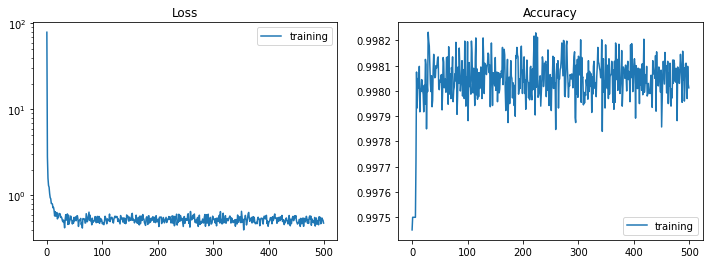

In [5]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [94]:
sigmoid = nn.Sigmoid()
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

Created dataset for events from 0 to 198917


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

In [80]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600,7000,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


Text(0, 0.5, 'True positive rate')

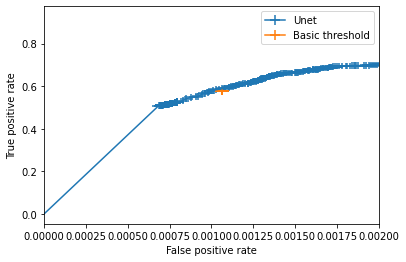

In [81]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.002])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [82]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

NN ------------------
[Threshold 0.0001] TP = 0.92, FP = 0.13966416040100232
[Threshold 0.00010181590626169435] TP = 0.92, FP = 0.1384636591478696
[Threshold 0.00010366478767890119] TP = 0.92, FP = 0.13735338345864667
[Threshold 0.0001055472430495345] TP = 0.92, FP = 0.13626315789473678
[Threshold 0.00010746388204511664] TP = 0.919, FP = 0.13511528822055136
[Threshold 0.00010941532540823375] TP = 0.919, FP = 0.1339072681704259
[Threshold 0.000111402205153575] TP = 0.919, FP = 0.1325563909774436
[Threshold 0.00011342516477262434] TP = 0.919, FP = 0.1315338345864661
[Threshold 0.00011548485944206743] TP = 0.919, FP = 0.13031328320802005
[Threshold 0.00011758195623598486] TP = 0.919, FP = 0.12920050125313287
[Threshold 0.00011971713434189669] TP = 0.919, FP = 0.12820551378446113
[Threshold 0.00012189108528073223] TP = 0.919, FP = 0.1270927318295739
[Threshold 0.0001241045131307921] TP = 0.918, FP = 0.12591478696741856
[Threshold 0.00012635813475577945] TP = 0.918, FP = 0.12483208020050111

In [ ]:
evt_plt = 100001
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_10cells_noise_100k_74.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_10cells_noise_100k_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

Text(0.5, 1.0, 'Accuracy')

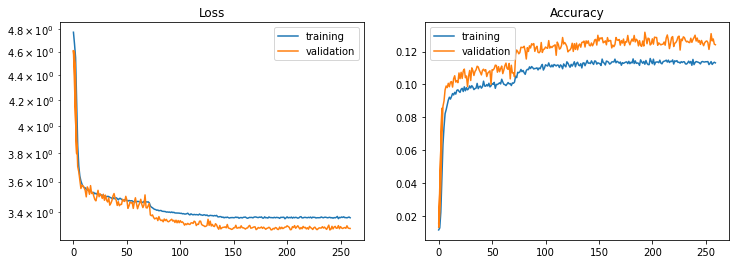

In [103]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(80000,81000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.02
sigma_cut = 1e9
plt.hist(df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN,alpha=0.8,bins=50,color='blue',label='NN error')
plt.hist(df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3,alpha=0.8,bins=50,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
plt.yscale('log')
plt.legend()

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 81001
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX + dset.add_shift*emnet.PIXEL_SIZE
ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))